# Initial

In [ ]:
# %% #### Imports ####
import pandas as pd
import seaborn as sns
import json
from HSSL import *
from scipy.cluster.hierarchy import cophenet
from benchmark.results import load_all_results

/mnt/large_storage/cabi/hnsw_searchers/HSSL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
            is_efficient[i] = True
    return is_efficient

In [3]:
def get_pareto_frontier(df, x, y, split):
    # removes all rows that don't lie on the pareto frontier
    to_plot = df.sort_values(x, ascending=True).reset_index(drop=True)
    d = {} # store last x values
    drop_list = []
    for algo in set(df[split]):
        d[algo] = 0
    for i in range(len(to_plot)):
        x_ = to_plot.iloc[i][x]
        y_ = to_plot.iloc[i][y]
        algo = to_plot.iloc[i][split]
        if y_ > d[algo]:
            d[algo] = y_
        else:
            drop_list.append(i)
    to_plot.drop(drop_list, inplace=True)
        
    return to_plot

# Quality Measurements

## Quality Measurements ALOI hssl

gt_coph_dist took: 113.46230149269104s
coph_dist took: 116.57969737052917s


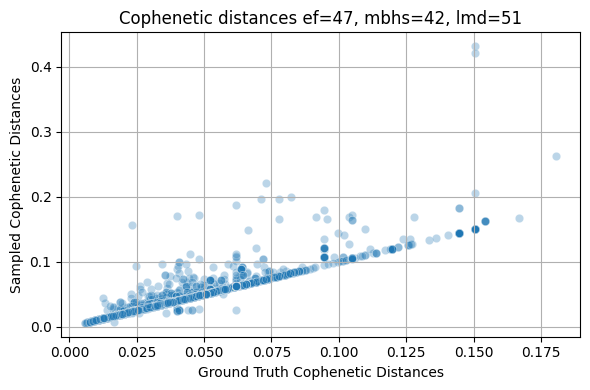

0.037836694198275275
norm took: 0.9932992458343506s
coph_dist took: 132.99142861366272s


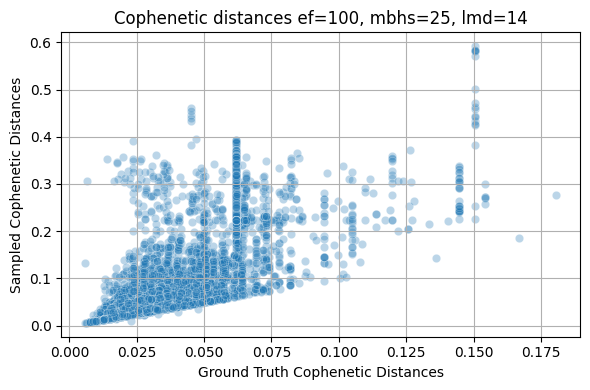

0.5678913896824715
norm took: 0.9757096767425537s
coph_dist took: 112.68078422546387s


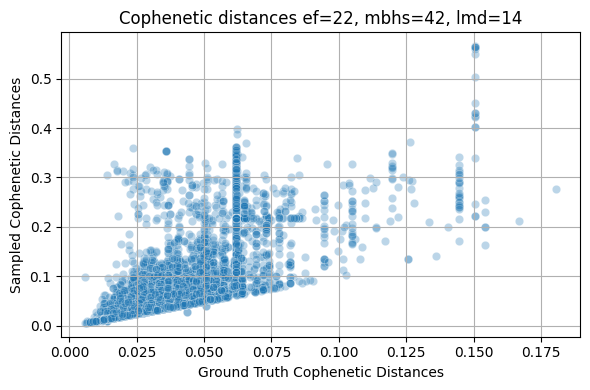

0.4969093319262323
norm took: 0.9842112064361572s
coph_dist took: 129.33682084083557s


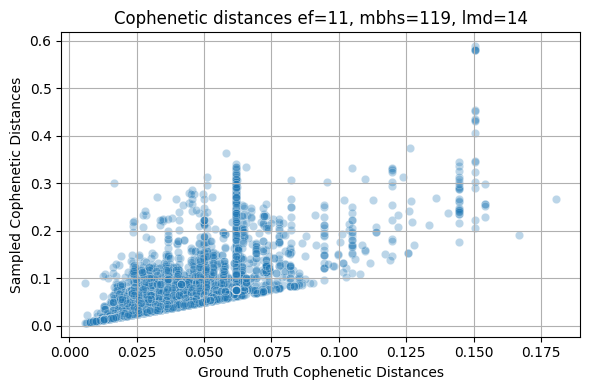

0.23060271813290348
norm took: 0.976170539855957s
coph_dist took: 116.05941486358643s


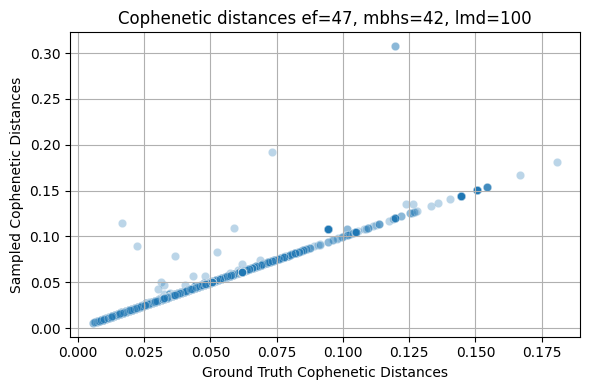

0.016249136600610035
norm took: 0.9789810180664062s
coph_dist took: 133.94908952713013s


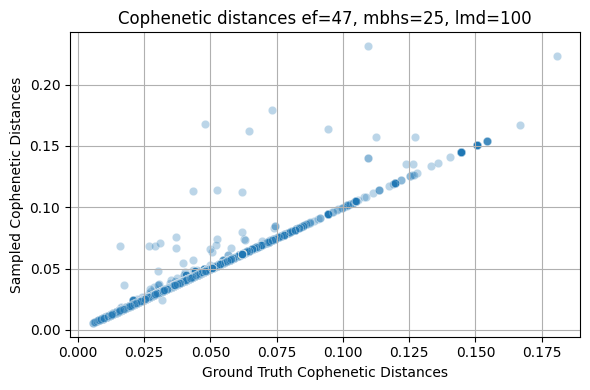

0.020593795381644964
norm took: 0.9749147891998291s
coph_dist took: 135.12934470176697s


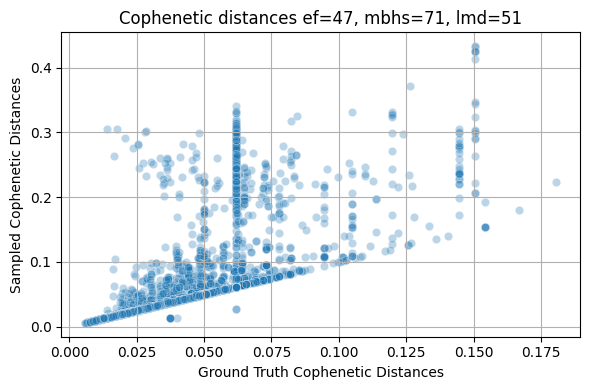

0.24868413114124135
norm took: 1.0554020404815674s
coph_dist took: 133.26453304290771s


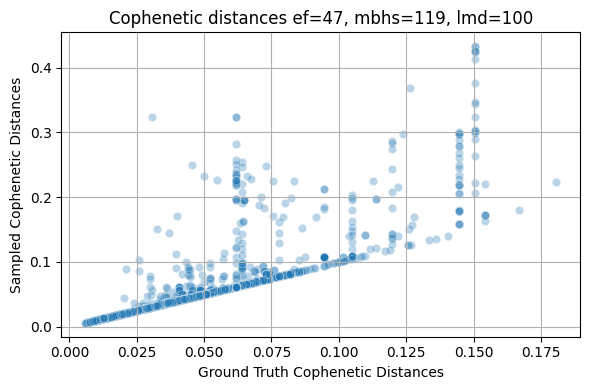

0.09589404748655175
norm took: 0.9788031578063965s
coph_dist took: 116.77343106269836s


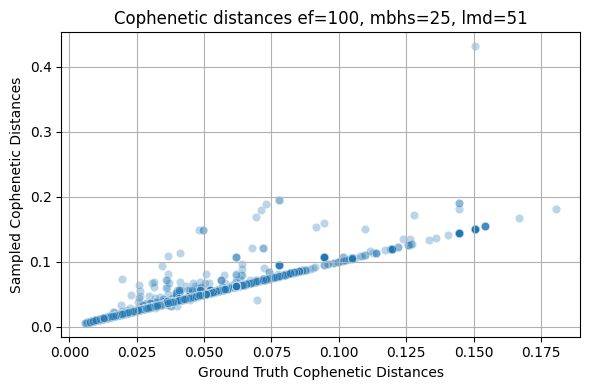

0.028541616224637925
norm took: 0.9806978702545166s
coph_dist took: 127.59619188308716s


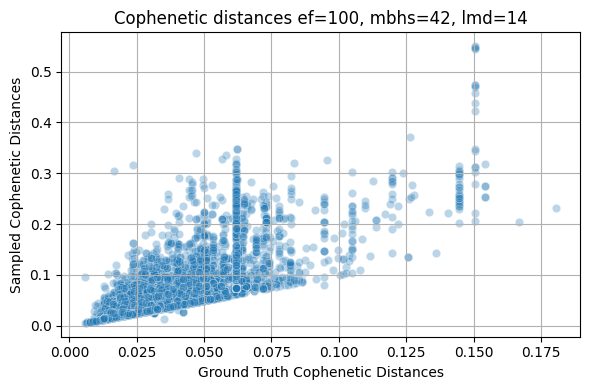

0.2461743986669724
norm took: 0.9801182746887207s
coph_dist took: 112.72485876083374s
0.393935614207102
norm took: 0.963442325592041s
coph_dist took: 131.63186264038086s
0.2437663407016565
norm took: 0.967864990234375s
coph_dist took: 114.22121691703796s
0.45217488967969016
norm took: 1.033888339996338s
coph_dist took: 134.6423327922821s
0.01828745778535073
norm took: 0.9710640907287598s
coph_dist took: 116.88595509529114s
0.11293715048133783
norm took: 0.9801404476165771s
coph_dist took: 124.5309374332428s
0.11065923954544984
norm took: 0.9793701171875s
coph_dist took: 110.55129599571228s
0.4820498848166174
norm took: 0.9717807769775391s
coph_dist took: 121.34422135353088s
0.37153585695735286
norm took: 0.9786298274993896s
coph_dist took: 111.1218831539154s
0.5461830984149639
norm took: 0.9696948528289795s
coph_dist took: 119.51455903053284s
0.4204049534471989
norm took: 0.9875755310058594s
coph_dist took: 112.2101776599884s
0.16389802191505043
norm took: 0.9763362407684326s
coph_dist

algo         time       n  \
0  HNSWhssl  1259.796838  110000   
1  HNSWhssl   738.393064  110000   
2  HNSWhssl   217.892790  110000   
3  HNSWhssl   148.220747  110000   
4  HNSWhssl  1715.129140  110000   

                                              params      norm  
0  {"ef": 47, "params": {"higher_max_degree": 25,...  0.962163  
1  {"ef": 100, "params": {"higher_max_degree": 7,...  0.432109  
2  {"ef": 22, "params": {"higher_max_degree": 7, ...  0.503091  
3  {"ef": 11, "params": {"higher_max_degree": 7, ...  0.769397  
4  {"ef": 47, "params": {"higher_max_degree": 50,...  0.983751

In [4]:
## -- aloi-hssl -- ##
import time
import itertools

dataset = 'aloi733-110k'

ef = [5, 11, 22, 47, 100]
mbhs = [25, 42, 71, 119, 200]
lmd = [14, 26, 51, 100]

combinations = list(itertools.product(ef, mbhs, lmd))

data = []


for f in load_all_results(dataset, ""):
    try:
        if f.attrs['algo'] != 'scipy': continue
        gt_dendro = f["dendrogram"][:]
        gt_dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in gt_dendro]
        gt_dendro = elki_sort_dendrogram(gt_dendro)
        start = time.time()
        gt_coph_dists = cophenet(gt_dendro)
        end = time.time()
        t = end - start
        print(f"gt_coph_dist took: {t}s")
    finally:
        f.close()

indices = np.random.choice(gt_coph_dists.shape[0], size=10_000_000, replace=False)

temp = 0
for f in load_all_results(dataset, ""):
    if f.attrs['algo'] != "HNSWhssl": continue
    params = json.loads(f.attrs["params"])
    
    if (params['ef'], 
        params['params']['max_build_heap_size'], 
        params['params']['lowest_max_degree']) not in combinations: continue
    
    try:
        dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in f["dendrogram"][:]]
        dendro = elki_sort_dendrogram(dendro)

        start = time.time()
        coph_dists = cophenet(dendro)
        end = time.time()
        t = end - start
        print(f"coph_dist took: {t}s")

        sampled_gt_coph_dists = gt_coph_dists[indices]
        sampled_coph_dists = coph_dists[indices]

        temp += 1
        if temp <= 10:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=sampled_gt_coph_dists[0:10000], y=sampled_coph_dists[0:10000], alpha=0.3)
            plt.title(f"Cophenetic distances ef={params['ef']}, mbhs={params['params']['max_build_heap_size']}, lmd={params['params']['lowest_max_degree']}")
            plt.xlabel("Ground Truth Cophenetic Distances")
            plt.ylabel("Sampled Cophenetic Distances")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        start = time.time()
        max_diff = max(sampled_gt_coph_dists) - min(sampled_gt_coph_dists)
        norm = np.linalg.norm(sampled_gt_coph_dists - sampled_coph_dists) / ( np.sqrt(len(sampled_gt_coph_dists)) * max_diff )
        print(norm)
        end = time.time()
        t = end - start
        print(f"norm took: {t}s")

        data.append({
        "algo": f.attrs['algo'],
        "time": f.attrs['time'],
        "n": len(f["dendrogram"][:]) + 1,
        "params": f.attrs["params"],
        "norm": 1 - norm, 
        })
    finally:
        f.close()

df_ALOIhssl = pd.DataFrame(data=data)
df_ALOIhssl.head(5)

In [5]:
df_ALOIhssl_split = df_ALOIhssl
df_ALOIhssl_split["params_dict"] = df_ALOIhssl_split["params"].apply(lambda x: json.loads(x))
df_ef = df_ALOIhssl_split["params_dict"].apply(lambda d: d.get("ef")).rename("ef").to_frame()
df_params = df_ALOIhssl_split["params_dict"].apply(lambda d: d.get("params", {})).apply(pd.Series)
df_ALOIhssl_split = pd.concat([df_ALOIhssl_split, df_ef[['ef']], df_params[["lowest_max_degree", "max_build_heap_size"]]], axis=1)

df_ALOIhssl_split

algo         time       n  \
0   HNSWhssl  1259.796838  110000   
1   HNSWhssl   738.393064  110000   
2   HNSWhssl   217.892790  110000   
3   HNSWhssl   148.220747  110000   
4   HNSWhssl  1715.129140  110000   
..       ...          ...     ...   
74  HNSWhssl   853.426750  110000   
75  HNSWhssl  1984.196803  110000   
76  HNSWhssl   524.081302  110000   
77  HNSWhssl   849.265841  110000   
78  HNSWhssl   333.024967  110000   

                                               params      norm  \
0   {"ef": 47, "params": {"higher_max_degree": 25,...  0.962163   
1   {"ef": 100, "params": {"higher_max_degree": 7,...  0.432109   
2   {"ef": 22, "params": {"higher_max_degree": 7, ...  0.503091   
3   {"ef": 11, "params": {"higher_max_degree": 7, ...  0.769397   
4   {"ef": 47, "params": {"higher_max_degree": 50,...  0.983751   
..                                                ...       ...   
74  {"ef": 100, "params": {"higher_max_degree": 7,...  0.511550   
75  {"ef": 100, "params": {"higher_max_degree": 25...  0.817528   
76  {"ef": 11, "params": {"higher_max_degree": 25,...  0.958949   
77  {"ef": 11, "params": {"higher_max_degree": 50,...  0.908800   
78  {"ef": 22, "params": {"higher_max_degree": 13,...  0.602990   

                                          params_dict   ef  lowest_max_degree  \
0   {'ef': 47, 'params': {'higher_max_degree': 25,...   47                 51   
1   {'ef': 100, 'params': {'higher_max_degree': 7,...  100                 14   
2   {'ef': 22, 'params': {'higher_max_degree': 7, ...   22                 14   
3   {'ef': 11, 'params': {'higher_max_degree': 7, ...   11                 14   
4   {'ef': 47, 'params': {'higher_max_degree': 50,...   47                100   
..                                                ...  ...                ...   
74  {'ef': 100, 'params': {'higher_max_degree': 7,...  100                 14   
75  {'ef': 100, 'params': {'higher_max_degree': 25...  100                 51   
76  {'ef': 11, 'params': {'higher_max_degree': 25,...   11                 51   
77  {'ef': 11, 'params': {'higher_max_degree': 50,...   11                100   
78  {'ef': 22, 'params': {'higher_max_degree': 13,...   22                 26   

    max_build_heap_size  
0                    42  
1                    25  
2                    42  
3                   119  
4                    42  
..                  ...  
74                   71  
75                  200  
76                   25  
77                  119  
78                   42  

[79 rows x 9 columns]

In [6]:
df_ALOIhssl_split.to_csv('ALOIhssl_norm.csv', index=False)

In [7]:
df_ALOIhssl_split = df_ALOIhssl_split[["algo", "time", "norm", "ef", "max_build_heap_size", "lowest_max_degree"]]

pareto_aloihssl = get_pareto_frontier(df_ALOIhssl_split, "time", "norm", "algo")

pareto_aloihssl[["time", "norm", "ef", "max_build_heap_size", "lowest_max_degree"]]

time      norm  ef  max_build_heap_size  lowest_max_degree
0   148.220747  0.769397  11                  119                 14
5   225.746739  0.824919   5                   42                 26
9   234.287057  0.857013  11                  200                 26
18  414.792964  0.857204   5                   71                 51
19  419.633871  0.867424   5                  200                 51
22  432.355709  0.964620   5                   25                 51
27  551.127508  0.980719   5                   25                100
49  911.739356  0.986451   5                   71                100

In [8]:
filtered_df = pareto_aloihssl[pareto_aloihssl["norm"] > 0.8]

opt = filtered_df[filtered_df.time == filtered_df.time.min()]

opt[["time", "norm", "ef", "max_build_heap_size", "lowest_max_degree"]]

time      norm  ef  max_build_heap_size  lowest_max_degree
5  225.746739  0.824919   5                   42                 26

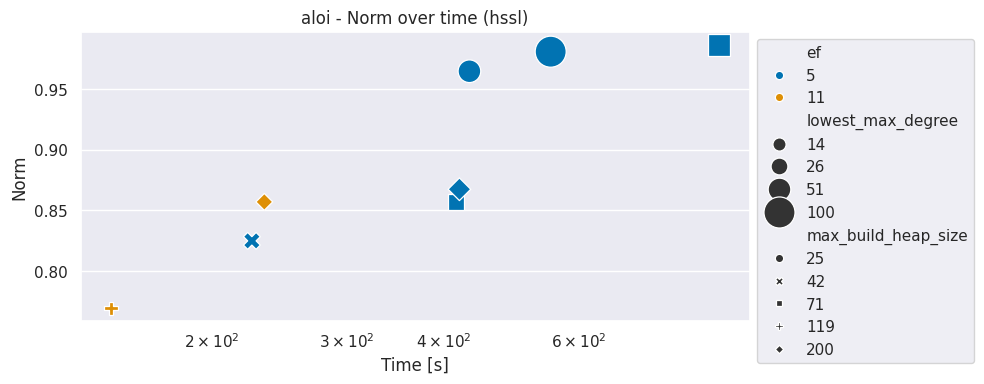

In [9]:
sns.set(style="darkgrid")
ax = plt.figure(figsize=(10, 4))

sns.scatterplot(data=pareto_aloihssl, x="time", y="norm", 
                hue="ef",
                style="max_build_heap_size", 
                size="lowest_max_degree", 
                palette="colorblind", 
                # markers={True: "X", False: "o"},
                sizes=(90, 500))

plt.title(f"aloi - Norm over time (hssl)")
plt.xlabel("Time [s]")
plt.ylabel("Norm")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.xscale("log")

plt.show()

## Quality Measurements ALOI Kruskal

{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 5, 'lowest_max_degree': 10, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 13, 'lowest_max_degree': 26, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 42, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 13, 'lowest_max_degree': 26, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 25, 'max_build_frontier_size': None, 'level_norm_param_override'

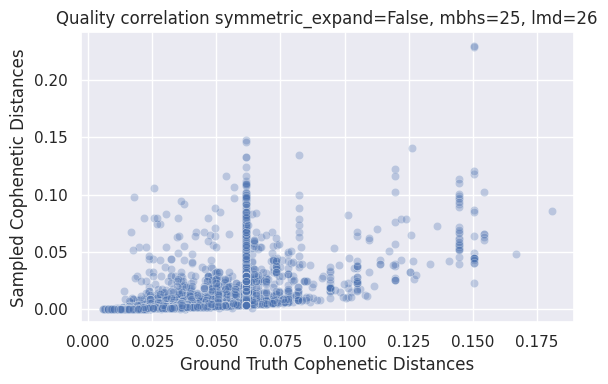

0.19434821217906864
norm took: 0.972161054611206s
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 50, 'lowest_max_degree': 100, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 25, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 5, 'lowest_max_degree': 10, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 25, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 9, 'lowest_max_degree': 19, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 25, 'max_build_

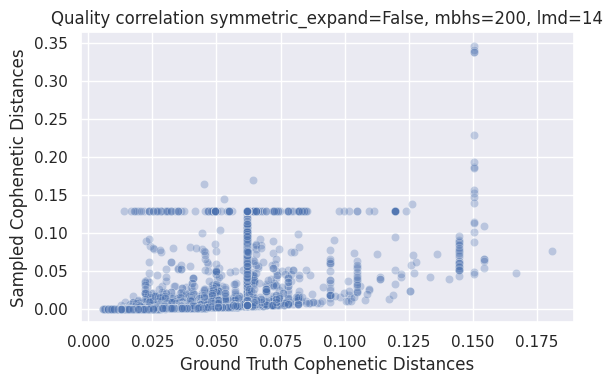

0.20958916282371462
norm took: 0.9739747047424316s
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 18, 'lowest_max_degree': 37, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 36, 'lowest_max_degree': 72, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 18, 'lowest_max_degree': 37, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 42, 'max_bui

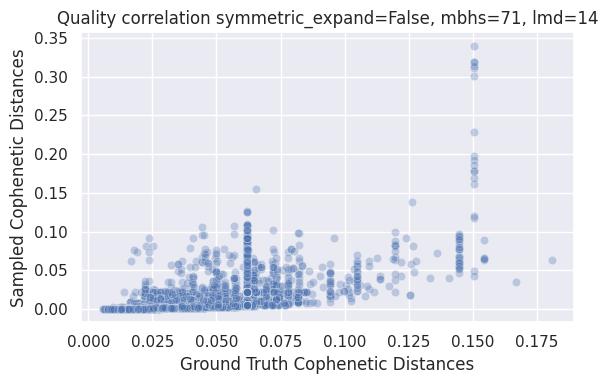

0.18096431741919006
norm took: 0.9916174411773682s
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 25, 'lowest_max_degree': 51, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
109999
coph_dist took: 118.4268524646759s


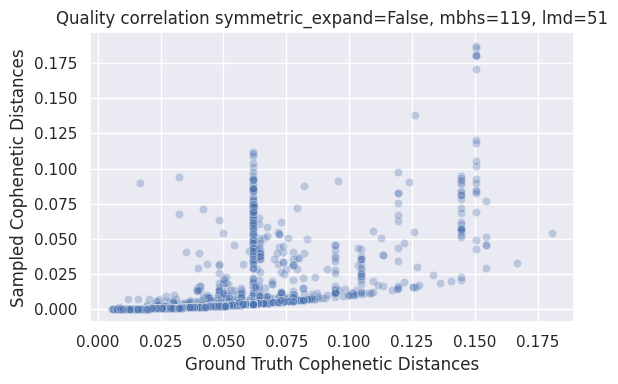

0.21199579888007258
norm took: 0.9768762588500977s
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 9, 'lowest_max_degree': 19, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 42, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 13, 'lowest_max_degree': 26, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
109999
coph_dist took: 115.03511595726013s


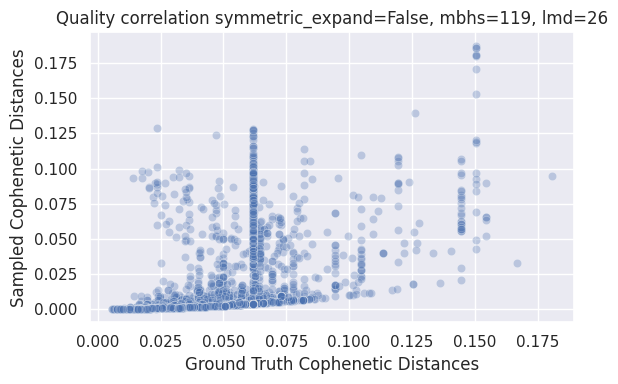

0.19162855941319976
norm took: 0.973301887512207s
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 7, 'lowest_max_degree': 14, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 36, 'lowest_max_degree': 72, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 25, 'lowest_max_degree': 51, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_build_

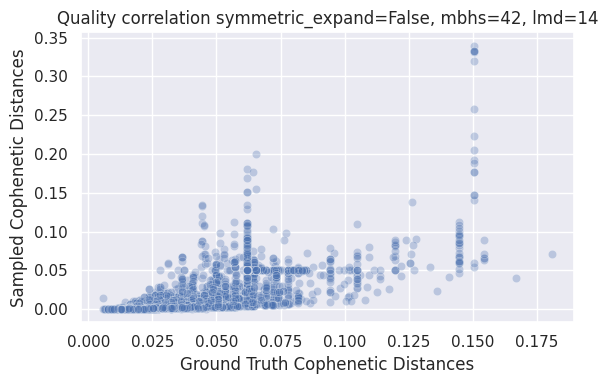

0.15440156235254265
norm took: 0.972235918045044s
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 13, 'lowest_max_degree': 26, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 42, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
109999
coph_dist took: 113.0216875076294s


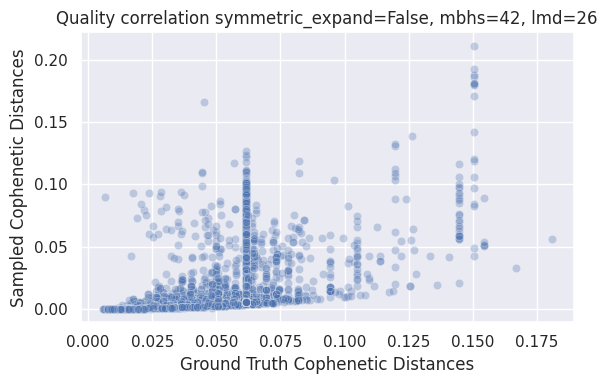

0.19510521060896524
norm took: 0.9753592014312744s
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 7, 'lowest_max_degree': 14, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 25, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
109999
coph_dist took: 112.28039288520813s


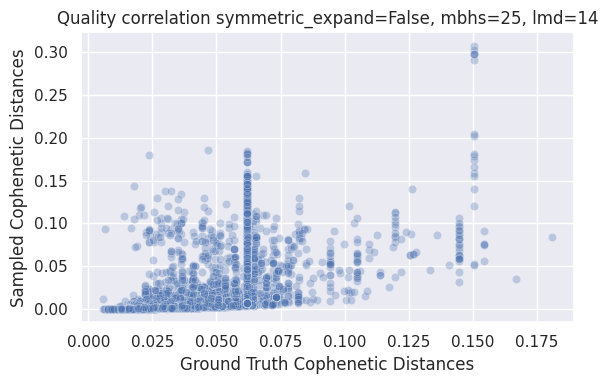

0.17182467964652076
norm took: 1.0505552291870117s
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 13, 'lowest_max_degree': 26, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 25, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 9, 'lowest_max_degree': 19, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 9, 'lowest_max_degree': 19, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 200, 'max_buil

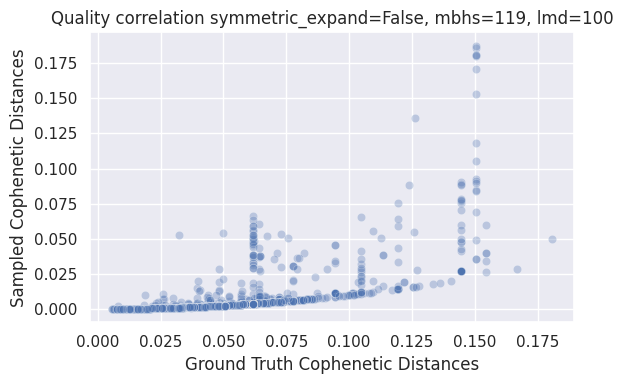

0.2164708511377907
norm took: 1.0228118896484375s
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 50, 'lowest_max_degree': 100, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 5, 'lowest_max_degree': 10, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 5, 'lowest_max_degree': 10, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_buil

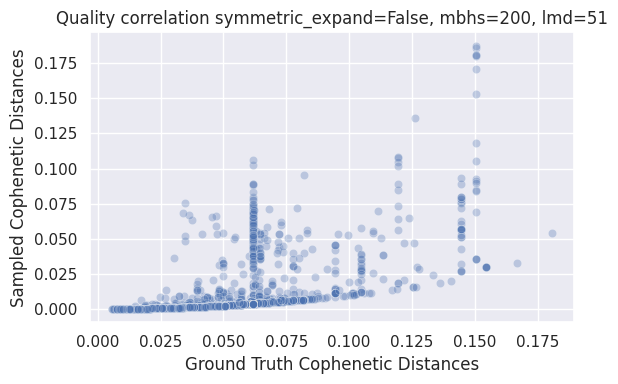

0.21114803622155381
norm took: 1.0681049823760986s
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 36, 'lowest_max_degree': 72, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 50, 'lowest_max_degree': 100, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 13, 'lowest_max_degree': 26, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_b

algo       time       n  \
0  HNSWkruskal  20.483412  110000   
1  HNSWkruskal  22.424158  110000   
2  HNSWkruskal  23.396780  110000   
3  HNSWkruskal  29.983921  110000   
4  HNSWkruskal  19.457742  110000   

                                              params      norm  
0  {"minPts": 1, "symmetric_expand": false, "para...  0.805652  
1  {"minPts": 1, "symmetric_expand": false, "para...  0.790411  
2  {"minPts": 1, "symmetric_expand": false, "para...  0.819036  
3  {"minPts": 1, "symmetric_expand": false, "para...  0.788004  
4  {"minPts": 1, "symmetric_expand": false, "para...  0.808371

In [10]:
## -- aloi-kruskal -- ##
import time
import itertools

dataset = 'aloi733-110k'

se = [False]
mbhs = [25, 42, 71, 119, 200]
lmd = [14, 26, 51, 100]

# Generate all combinations
combinations = list(itertools.product(se, mbhs, lmd))

data = []


temp = 0
error_count = 0
for f in load_all_results(dataset, ""):
    if f.attrs['algo'] != "HNSWkruskal": continue
    params = json.loads(f.attrs["params"])
    print(params)
    
    if (params['symmetric_expand'],
        params['params']['max_build_heap_size'], 
        params['params']['lowest_max_degree']) not in combinations: continue
    try:
        dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in f["dendrogram"][:]]
        print(len(dendro))
        dendro = elki_sort_dendrogram(dendro)

        try:
            start = time.time()
            coph_dists = cophenet(dendro)
            end = time.time()
            t = end - start
            print(f"coph_dist took: {t}s")
        except:
            print("ERROR in cophenet")
            error_count += 1

        sampled_gt_coph_dists = gt_coph_dists[indices]
        sampled_coph_dists = coph_dists[indices]

        temp += 1
        if temp <= 10:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=sampled_gt_coph_dists[0:10000], y=sampled_coph_dists[0:10000], alpha=0.3)
            plt.title(f"Quality correlation symmetric_expand={params['symmetric_expand']}, mbhs={params['params']['max_build_heap_size']}, lmd={params['params']['lowest_max_degree']}")
            plt.xlabel("Ground Truth Cophenetic Distances")
            plt.ylabel("Sampled Cophenetic Distances")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        start = time.time()
        max_diff = max(sampled_gt_coph_dists) - min(sampled_gt_coph_dists)
        norm = np.linalg.norm(sampled_gt_coph_dists - sampled_coph_dists) / ( np.sqrt(len(sampled_gt_coph_dists)) * max_diff )
        print(norm)
        end = time.time()
        t = end - start
        print(f"norm took: {t}s")

        data.append({
        "algo": f.attrs['algo'],
        "time": f.attrs['time'],
        "n": len(f["dendrogram"][:]) + 1,
        "params": f.attrs["params"],
        "norm": 1 - norm,
        })
    finally:
        f.close()

print(error_count)
df_ALOIkruskal = pd.DataFrame(data=data)
df_ALOIkruskal.head(5)

In [11]:
df_ALOIkruskal_split = df_ALOIkruskal
df_ALOIkruskal_split["params_dict"] = df_ALOIkruskal_split["params"].apply(lambda x: json.loads(x))
df_ef = df_ALOIkruskal_split["params_dict"].apply(lambda d: d.get("symmetric_expand")).rename("symmetric_expand").to_frame()
df_params = df_ALOIkruskal_split["params_dict"].apply(lambda d: d.get("params", {})).apply(pd.Series)
df_ALOIkruskal_split = pd.concat([df_ALOIkruskal_split, df_ef[['symmetric_expand']], df_params[["lowest_max_degree", "max_build_heap_size"]]], axis=1)

df_ALOIkruskal_split

algo       time       n  \
0   HNSWkruskal  20.483412  110000   
1   HNSWkruskal  22.424158  110000   
2   HNSWkruskal  23.396780  110000   
3   HNSWkruskal  29.983921  110000   
4   HNSWkruskal  19.457742  110000   
5   HNSWkruskal  21.675168  110000   
6   HNSWkruskal  19.336518  110000   
7   HNSWkruskal  21.242225  110000   
8   HNSWkruskal  39.380983  110000   
9   HNSWkruskal  29.398487  110000   
10  HNSWkruskal  20.042995  110000   
11  HNSWkruskal  28.957410  110000   
12  HNSWkruskal  35.010701  110000   
13  HNSWkruskal  40.389269  110000   
14  HNSWkruskal  40.840670  110000   
15  HNSWkruskal  22.713454  109999   
16  HNSWkruskal  20.480727  110000   
17  HNSWkruskal  33.386015  110000   
18  HNSWkruskal  27.363239  110000   
19  HNSWkruskal  28.736077  110000   

                                               params      norm  \
0   {"minPts": 1, "symmetric_expand": false, "para...  0.805652   
1   {"minPts": 1, "symmetric_expand": false, "para...  0.790411   
2   {"minPts": 1, "symmetric_expand": false, "para...  0.819036   
3   {"minPts": 1, "symmetric_expand": false, "para...  0.788004   
4   {"minPts": 1, "symmetric_expand": false, "para...  0.808371   
5   {"minPts": 1, "symmetric_expand": false, "para...  0.845598   
6   {"minPts": 1, "symmetric_expand": false, "para...  0.804895   
7   {"minPts": 1, "symmetric_expand": false, "para...  0.828175   
8   {"minPts": 1, "symmetric_expand": false, "para...  0.783529   
9   {"minPts": 1, "symmetric_expand": false, "para...  0.788852   
10  {"minPts": 1, "symmetric_expand": false, "para...  0.815134   
11  {"minPts": 1, "symmetric_expand": false, "para...  0.802222   
12  {"minPts": 1, "symmetric_expand": false, "para...  0.778674   
13  {"minPts": 1, "symmetric_expand": false, "para...  0.778666   
14  {"minPts": 1, "symmetric_expand": false, "para...  0.783034   
15  {"minPts": 1, "symmetric_expand": false, "para...  0.783034   
16  {"minPts": 1, "symmetric_expand": false, "para...  0.802779   
17  {"minPts": 1, "symmetric_expand": false, "para...  0.778877   
18  {"minPts": 1, "symmetric_expand": false, "para...  0.779550   
19  {"minPts": 1, "symmetric_expand": false, "para...  0.780298   

                                          params_dict  symmetric_expand  \
0   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
1   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
2   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
3   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
4   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
5   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
6   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
7   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
8   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
9   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
10  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
11  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
12  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
13  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
14  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
15  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
16  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
17  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
18  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
19  {'minPts': 1, 'symmetric_expand': False, 'para...             False   

    lowest_max_degree  max_build_heap_size  
0                  26                   25  
1                  14                  200  
2                  14                   71  
3                  51                  119  
4  

In [12]:
df_ALOIkruskal_split.to_csv('ALOIkruskal_norm.csv', index=False)

In [13]:
df_ALOIkruskal_split = df_ALOIkruskal_split[["algo", "time", "norm", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

pareto_aloikruskal = get_pareto_frontier(df_ALOIkruskal_split, "time", "norm", "algo")

pareto_aloikruskal[["time", "norm", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time      norm  symmetric_expand  max_build_heap_size  \
0  19.336518  0.804895             False                   42   
1  19.457742  0.808371             False                  119   
2  20.042995  0.815134             False                   71   
5  21.242225  0.828175             False                   25   
6  21.675168  0.845598             False                   42   

   lowest_max_degree  
0                 26  
1                 26  
2                 26  
5                 14  
6                 14

In [14]:
filtered_df = pareto_aloikruskal[pareto_aloikruskal["norm"] > 0.8]

opt = filtered_df[filtered_df.time == filtered_df.time.min()]

opt[["time", "norm", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time      norm  symmetric_expand  max_build_heap_size  \
0  19.336518  0.804895             False                   42   

   lowest_max_degree  
0                 26

In [15]:
pareto_aloikruskal = pareto_aloikruskal[["time", "norm", "max_build_heap_size", "lowest_max_degree"]]

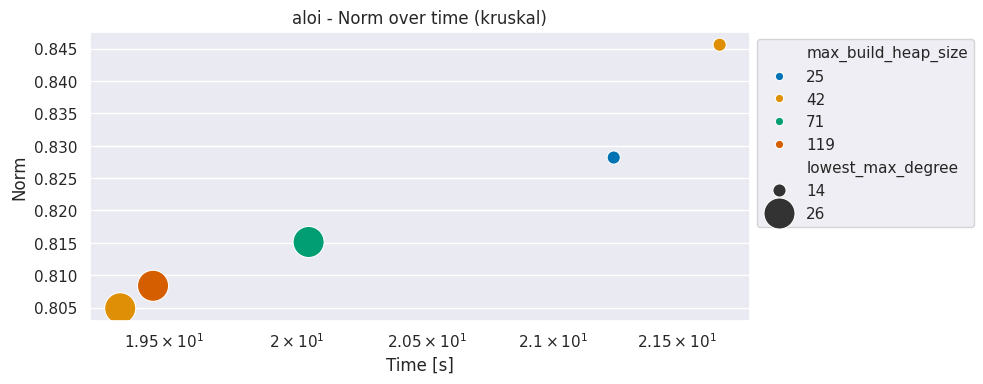

In [16]:
sns.set(style="darkgrid")
ax = plt.figure(figsize=(10, 4))

sns.scatterplot(data=pareto_aloikruskal, x="time", y="norm", 
                hue="max_build_heap_size",
                size="lowest_max_degree",
                palette="colorblind", 
                # markers={True: "X", False: "o"},
                sizes=(90, 500))

plt.title(f"aloi - Norm over time (kruskal)")
plt.xlabel("Time [s]")
plt.ylabel("Norm")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.xscale("log")

plt.show()

## Quality Measurements ALOI MST

ERROR in cophenet


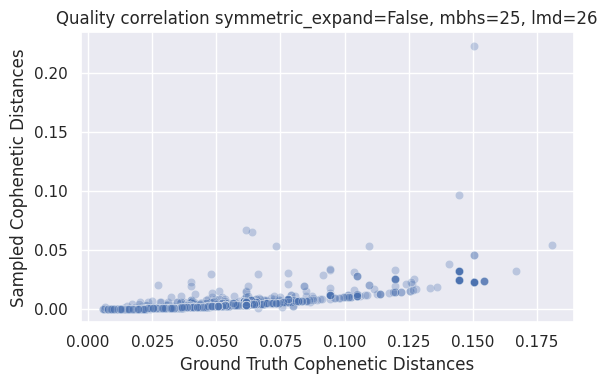

0.21970240370713667
norm took: 0.9540667533874512s
coph_dist took: 114.41692161560059s


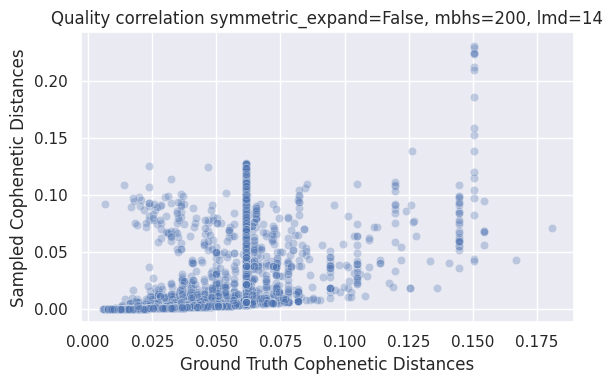

0.17301569879331383
norm took: 0.9788706302642822s
coph_dist took: 111.91739416122437s


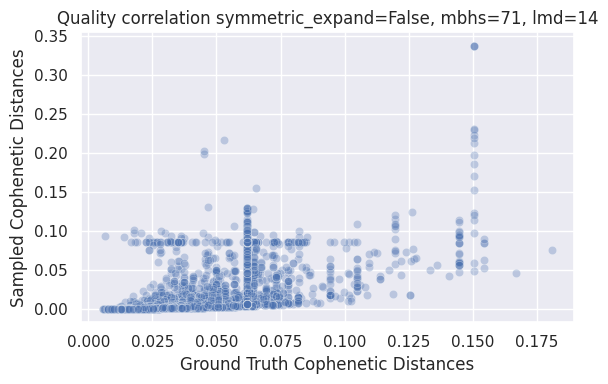

0.17070268753563267
norm took: 0.9750337600708008s
coph_dist took: 118.31694293022156s


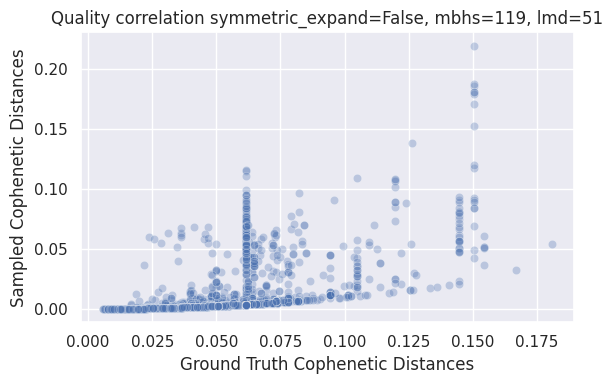

0.20795551006264182
norm took: 0.9717092514038086s
coph_dist took: 113.25304460525513s


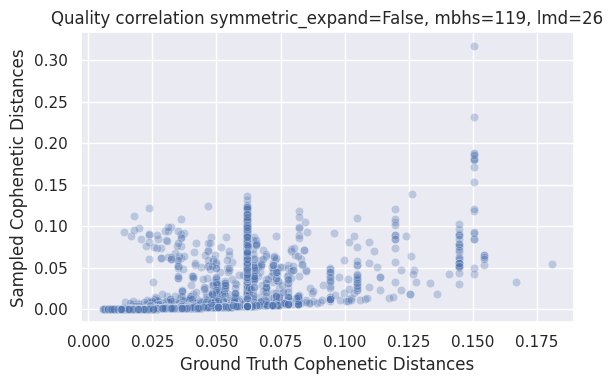

0.19214292681982442
norm took: 0.9741463661193848s
coph_dist took: 112.56507849693298s


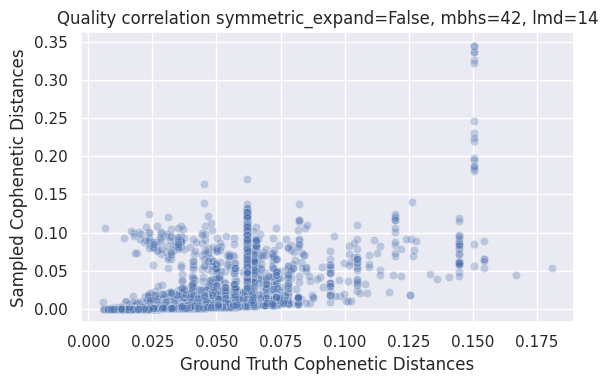

0.16220561761447497
norm took: 0.9726161956787109s
coph_dist took: 112.29881858825684s


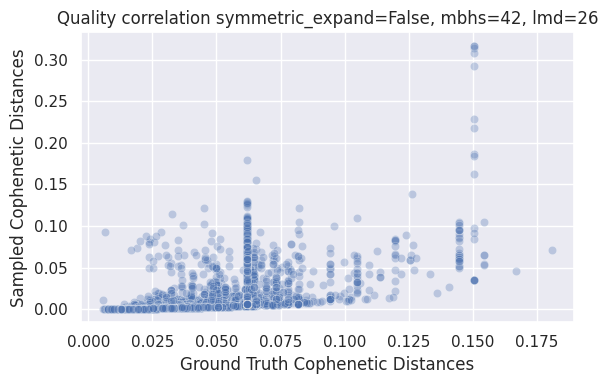

0.19589324916021922
norm took: 0.9747204780578613s
coph_dist took: 112.94399237632751s


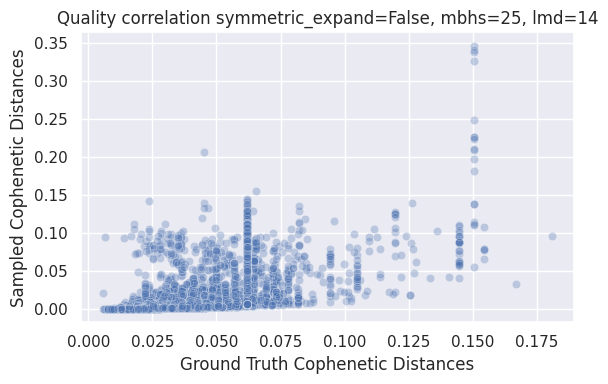

0.16371118646154828
norm took: 0.9729814529418945s
coph_dist took: 115.13107419013977s


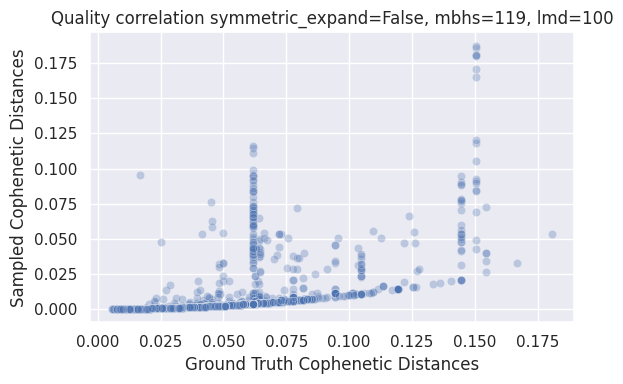

0.21557615074287945
norm took: 0.9837734699249268s
coph_dist took: 118.80853915214539s


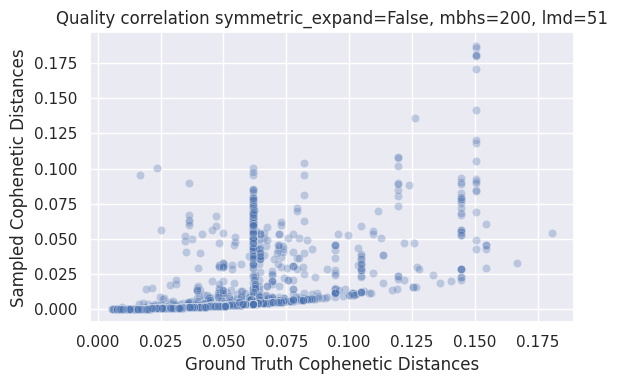

0.20916973213530934
norm took: 0.9697780609130859s
coph_dist took: 114.22985911369324s
0.20084363039497116
norm took: 0.9555830955505371s
coph_dist took: 118.67455840110779s
0.21305660885420682
norm took: 0.9750652313232422s
coph_dist took: 115.98208737373352s
0.22135144403623142
norm took: 0.9770803451538086s
coph_dist took: 119.61846423149109s
0.2212977298635158
norm took: 0.9759829044342041s
coph_dist took: 115.87274265289307s
0.2168236869649963
norm took: 0.9696063995361328s
coph_dist took: 114.36390733718872s
0.16971960762519914
norm took: 0.9890451431274414s
coph_dist took: 115.40811443328857s
0.20859102953947703
norm took: 0.9720070362091064s
coph_dist took: 119.96671748161316s
0.22104778928560012
norm took: 0.9769611358642578s
coph_dist took: 116.52916502952576s
0.21998248411741192
norm took: 0.9716229438781738s
coph_dist took: 119.99274706840515s
0.21990122560222777
norm took: 0.9649605751037598s
1


algo      time       n  \
0  HNSWmst  1.190757  109997   
1  HNSWmst  1.454089  110000   
2  HNSWmst  1.038746  110000   
3  HNSWmst  2.550881  110000   
4  HNSWmst  1.407947  110000   

                                              params      norm  
0  {"minPts": 1, "symmetric_expand": false, "para...  0.780298  
1  {"minPts": 1, "symmetric_expand": false, "para...  0.826984  
2  {"minPts": 1, "symmetric_expand": false, "para...  0.829297  
3  {"minPts": 1, "symmetric_expand": false, "para...  0.792044  
4  {"minPts": 1, "symmetric_expand": false, "para...  0.807857

In [17]:
## -- aloi-mst -- ##
import time
import itertools

dataset = 'aloi733-110k'

se = [False]
mbhs = [25, 42, 71, 119, 200]
lmd = [14, 26, 51, 100]

# Generate all combinations
combinations = list(itertools.product(se, mbhs, lmd))

data = []


temp = 0
error_count = 0
for f in load_all_results(dataset, ""):
    if f.attrs['algo'] != "HNSWmst": continue
    params = json.loads(f.attrs["params"])
    
    if (params['symmetric_expand'],
        params['params']['max_build_heap_size'], 
        params['params']['lowest_max_degree']) not in combinations: continue
    try:
        dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in f["dendrogram"][:]]
        dendro = elki_sort_dendrogram(dendro)

        try:
            start = time.time()
            coph_dists = cophenet(dendro)
            end = time.time()
            t = end - start
            print(f"coph_dist took: {t}s")
        except:
            print("ERROR in cophenet")
            error_count += 1

        sampled_gt_coph_dists = gt_coph_dists[indices]
        sampled_coph_dists = coph_dists[indices]

        temp += 1
        if temp <= 10:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=sampled_gt_coph_dists[0:10000], y=sampled_coph_dists[0:10000], alpha=0.3)
            plt.title(f"Quality correlation symmetric_expand={params['symmetric_expand']}, mbhs={params['params']['max_build_heap_size']}, lmd={params['params']['lowest_max_degree']}")
            plt.xlabel("Ground Truth Cophenetic Distances")
            plt.ylabel("Sampled Cophenetic Distances")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        start = time.time()
        max_diff = max(sampled_gt_coph_dists) - min(sampled_gt_coph_dists)
        norm = np.linalg.norm(sampled_gt_coph_dists - sampled_coph_dists) / ( np.sqrt(len(sampled_gt_coph_dists)) * max_diff )
        print(norm)
        end = time.time()
        t = end - start
        print(f"norm took: {t}s")

        data.append({
        "algo": f.attrs['algo'],
        "time": f.attrs['time'],
        "n": len(f["dendrogram"][:]) + 1,
        "params": f.attrs["params"],
        "norm": 1 - norm,
        })
    finally:
        f.close()

print(error_count)
df_ALOImst = pd.DataFrame(data=data)
df_ALOImst.head(5)

In [18]:
df_ALOImst_split = df_ALOImst
df_ALOImst_split["params_dict"] = df_ALOImst_split["params"].apply(lambda x: json.loads(x))
df_ef = df_ALOImst_split["params_dict"].apply(lambda d: d.get("symmetric_expand")).rename("symmetric_expand").to_frame()
df_params = df_ALOImst_split["params_dict"].apply(lambda d: d.get("params", {})).apply(pd.Series)
df_ALOImst_split = pd.concat([df_ALOImst_split, df_ef[['symmetric_expand']], df_params[["lowest_max_degree", "max_build_heap_size"]]], axis=1)

df_ALOImst_split

algo      time       n  \
0   HNSWmst  1.190757  109997   
1   HNSWmst  1.454089  110000   
2   HNSWmst  1.038746  110000   
3   HNSWmst  2.550881  110000   
4   HNSWmst  1.407947  110000   
5   HNSWmst  1.042305  110000   
6   HNSWmst  1.488958  110000   
7   HNSWmst  0.998609  110000   
8   HNSWmst  5.380768  110000   
9   HNSWmst  2.864119  110000   
10  HNSWmst  1.443940  110000   
11  HNSWmst  2.661298  110000   
12  HNSWmst  3.118906  110000   
13  HNSWmst  4.436683  110000   
14  HNSWmst  5.469712  110000   
15  HNSWmst  1.168811  110000   
16  HNSWmst  1.606784  110000   
17  HNSWmst  1.952028  110000   
18  HNSWmst  1.894300  110000   
19  HNSWmst  2.186197  110000   

                                               params      norm  \
0   {"minPts": 1, "symmetric_expand": false, "para...  0.780298   
1   {"minPts": 1, "symmetric_expand": false, "para...  0.826984   
2   {"minPts": 1, "symmetric_expand": false, "para...  0.829297   
3   {"minPts": 1, "symmetric_expand": false, "para...  0.792044   
4   {"minPts": 1, "symmetric_expand": false, "para...  0.807857   
5   {"minPts": 1, "symmetric_expand": false, "para...  0.837794   
6   {"minPts": 1, "symmetric_expand": false, "para...  0.804107   
7   {"minPts": 1, "symmetric_expand": false, "para...  0.836289   
8   {"minPts": 1, "symmetric_expand": false, "para...  0.784424   
9   {"minPts": 1, "symmetric_expand": false, "para...  0.790830   
10  {"minPts": 1, "symmetric_expand": false, "para...  0.799156   
11  {"minPts": 1, "symmetric_expand": false, "para...  0.786943   
12  {"minPts": 1, "symmetric_expand": false, "para...  0.778649   
13  {"minPts": 1, "symmetric_expand": false, "para...  0.778702   
14  {"minPts": 1, "symmetric_expand": false, "para...  0.783176   
15  {"minPts": 1, "symmetric_expand": false, "para...  0.830280   
16  {"minPts": 1, "symmetric_expand": false, "para...  0.791409   
17  {"minPts": 1, "symmetric_expand": false, "para...  0.778952   
18  {"minPts": 1, "symmetric_expand": false, "para...  0.780018   
19  {"minPts": 1, "symmetric_expand": false, "para...  0.780099   

                                          params_dict  symmetric_expand  \
0   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
1   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
2   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
3   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
4   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
5   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
6   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
7   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
8   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
9   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
10  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
11  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
12  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
13  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
14  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
15  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
16  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
17  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
18  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
19  {'minPts': 1, 'symmetric_expand': False, 'para...             False   

    lowest_max_degree  max_build_heap_size  
0                  26                   25  
1                  14                  200  
2                  14                   71  
3                  51                  119  
4                  26                  119  
5                  14                   42  
6             

In [19]:
df_ALOImst_split.to_csv('ALOImst_norm.csv', index=False)

In [20]:
df_ALOImst_split = df_ALOImst_split[["algo", "time", "norm", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

pareto_aloimst = get_pareto_frontier(df_ALOImst_split, "time", "norm", "algo")

pareto_aloimst[["time", "norm", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time      norm  symmetric_expand  max_build_heap_size  \
0  0.998609  0.836289             False                   25   
2  1.042305  0.837794             False                   42   

   lowest_max_degree  
0                 14  
2                 14

In [21]:
filtered_df = pareto_aloimst[pareto_aloimst["norm"] > 0.8]

opt = filtered_df[filtered_df.time == filtered_df.time.min()]

opt[["time", "norm", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time      norm  symmetric_expand  max_build_heap_size  \
0  0.998609  0.836289             False                   25   

   lowest_max_degree  
0                 14

In [22]:
pareto_aloimst = pareto_aloimst[["time", "norm", "max_build_heap_size", "lowest_max_degree"]]

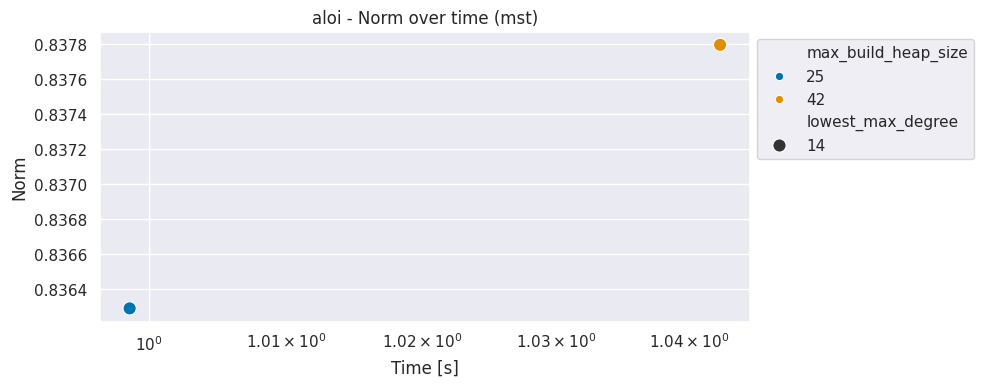

In [23]:
sns.set(style="darkgrid")
ax = plt.figure(figsize=(10, 4))

sns.scatterplot(data=pareto_aloimst, x="time", y="norm", 
                hue="max_build_heap_size",
                size="lowest_max_degree",
                palette="colorblind", 
                # markers={True: "X", False: "o"},
                sizes=(90, 500))

plt.title(f"aloi - Norm over time (mst)")
plt.xlabel("Time [s]")
plt.ylabel("Norm")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.xscale("log")

plt.show()

## Quality Measurements MNIST hssl

gt_coph_dist took: 43.86510682106018s
coph_dist took: 43.20259690284729s


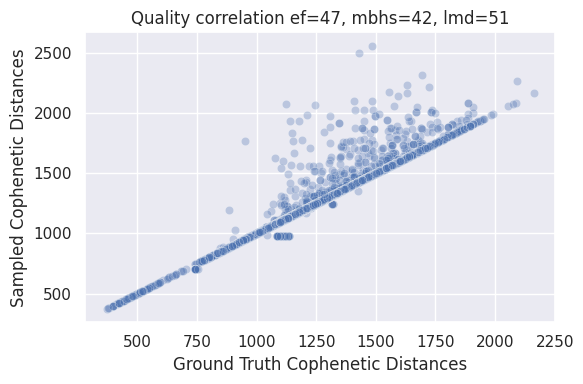

0.02851356158484337
norm took: 0.9548804759979248s
coph_dist took: 43.588767290115356s


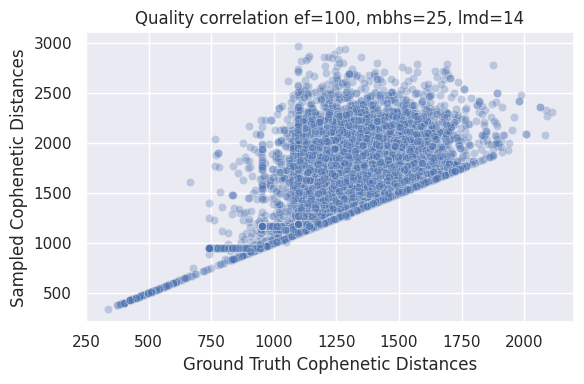

0.22794687504864136
norm took: 0.9895288944244385s
coph_dist took: 43.861074686050415s


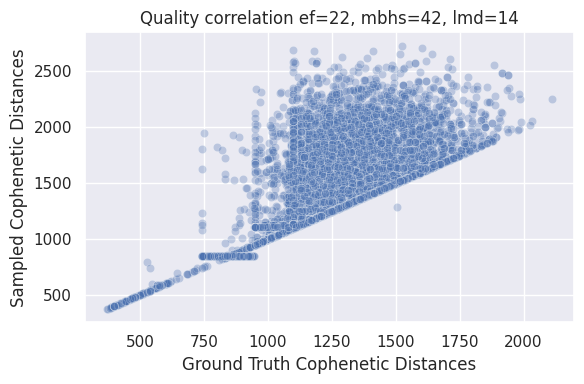

0.17670479570205455
norm took: 0.955467700958252s
coph_dist took: 43.462719202041626s


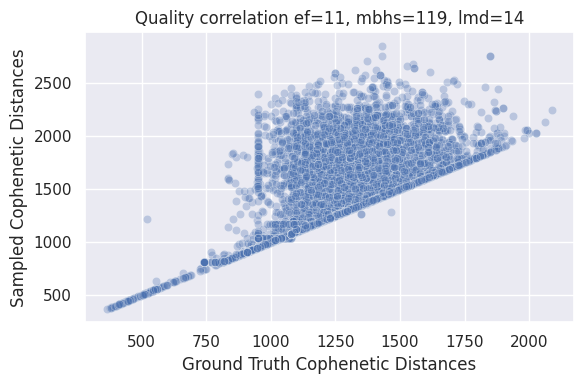

0.1695521039866958
norm took: 0.978245735168457s
coph_dist took: 43.137908697128296s


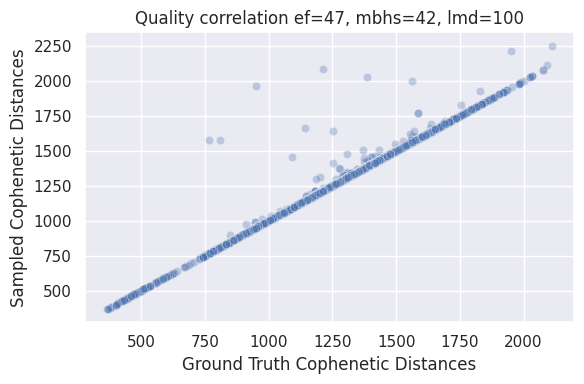

0.00993352701482414
norm took: 0.9861841201782227s
coph_dist took: 43.29185342788696s


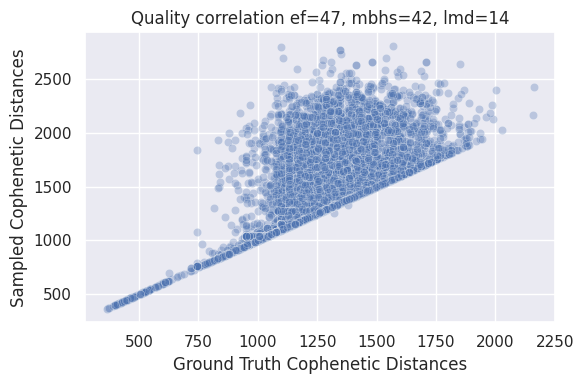

0.1731084643375263
norm took: 0.9714856147766113s
coph_dist took: 43.21130347251892s


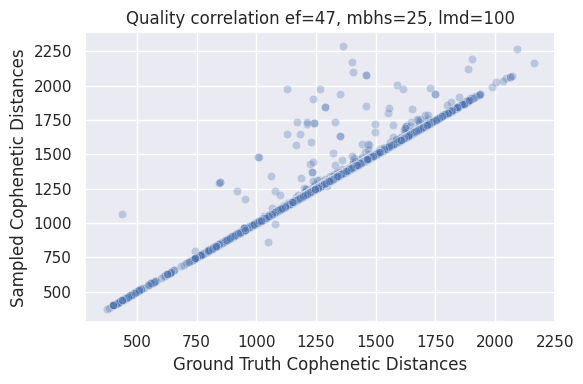

0.018074466111102624
norm took: 0.9856836795806885s
coph_dist took: 43.19148659706116s


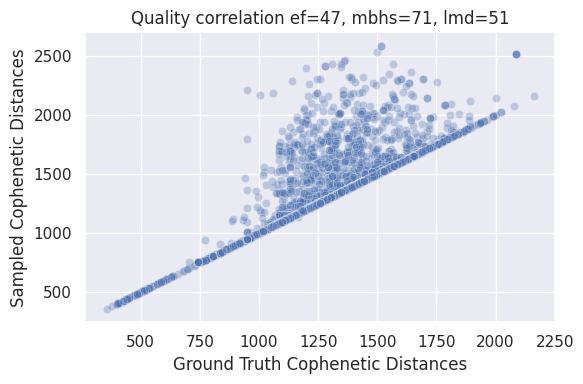

0.06321436513987824
norm took: 0.9866881370544434s
coph_dist took: 43.206329345703125s


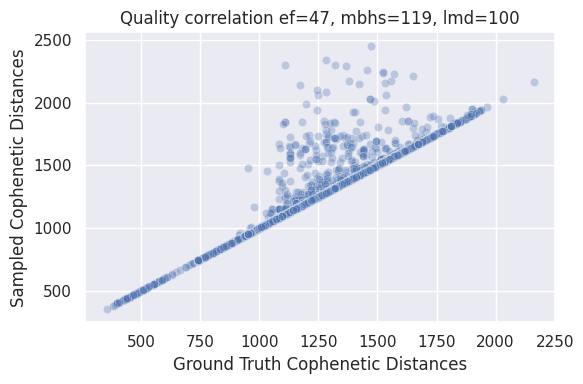

0.031603090212724415
norm took: 0.9671518802642822s
coph_dist took: 43.21970796585083s


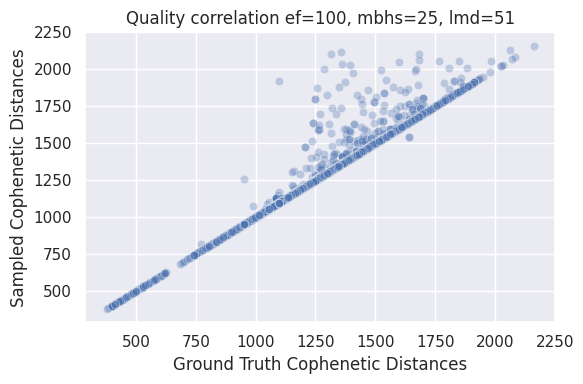

0.018116511982393235
norm took: 0.9716570377349854s
coph_dist took: 43.32947134971619s
0.22101143254260883
norm took: 0.9598526954650879s
coph_dist took: 43.580543756484985s
0.12322763554935422
norm took: 0.9612908363342285s
coph_dist took: 43.2700400352478s
0.05701819656015731
norm took: 0.966071605682373s
coph_dist took: 43.4026734828949s
0.13339517421264563
norm took: 0.975165605545044s
coph_dist took: 43.2301983833313s
0.008345356490899474
norm took: 0.9659104347229004s
coph_dist took: 43.439698934555054s
0.14525159925146783
norm took: 0.9745123386383057s
coph_dist took: 43.178149461746216s
0.06780386962988218
norm took: 0.968717098236084s
coph_dist took: 43.284034967422485s
0.030723902994593124
norm took: 0.974297046661377s
coph_dist took: 43.55795407295227s
0.15814891503161338
norm took: 0.9692671298980713s
coph_dist took: 43.550962686538696s
0.1388650895530434
norm took: 0.9753119945526123s
coph_dist took: 43.22755718231201s
0.08101308345231822
norm took: 1.0371737480163574s
cop

algo        time      n  \
0  HNSWhssl  804.777596  70000   
1  HNSWhssl  616.729362  70000   
2  HNSWhssl  179.858649  70000   
3  HNSWhssl  114.302616  70000   
4  HNSWhssl  983.602818  70000   

                                              params      norm  
0  {"ef": 47, "params": {"higher_max_degree": 25,...  0.971486  
1  {"ef": 100, "params": {"higher_max_degree": 7,...  0.772053  
2  {"ef": 22, "params": {"higher_max_degree": 7, ...  0.823295  
3  {"ef": 11, "params": {"higher_max_degree": 7, ...  0.830448  
4  {"ef": 47, "params": {"higher_max_degree": 50,...  0.990066

In [ ]:
## -- mnist-hssl -- ##
import time
import itertools

dataset = 'mnist-70k'

ef = [5, 11, 22, 47, 100]
mbhs = [25, 42, 71, 119, 200]
lmd = [14, 26, 51, 100]

combinations = list(itertools.product(ef, mbhs, lmd))

data = []


for f in load_all_results(dataset, ""):
    try:
        if f.attrs['algo'] != 'scipy': continue
        gt_dendro = f["dendrogram"][:]
        gt_dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in gt_dendro]
        gt_dendro = elki_sort_dendrogram(gt_dendro)
        start = time.time()
        gt_coph_dists = cophenet(gt_dendro)
        end = time.time()
        t = end - start
        print(f"gt_coph_dist took: {t}s")
    finally:
        f.close()
indices = np.random.choice(gt_coph_dists.shape[0], size=10_000_000, replace=False)

temp = 0
error_count = 0
for f in load_all_results(dataset, ""):
    if f.attrs['algo'] != "HNSWhssl": continue
    params = json.loads(f.attrs["params"])
    
    if (params['ef'], 
        params['params']['max_build_heap_size'], 
        params['params']['lowest_max_degree']) not in combinations: continue
    try:
        dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in f["dendrogram"][:]]
        dendro = elki_sort_dendrogram(dendro)

        try:
            start = time.time()
            coph_dists = cophenet(dendro)
            end = time.time()
            t = end - start
            print(f"coph_dist took: {t}s")
        except:
            print("ERROR in cophenet")
            error_count += 1

        sampled_gt_coph_dists = gt_coph_dists[indices]
        sampled_coph_dists = coph_dists[indices]

        temp += 1
        if temp <= 10:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=sampled_gt_coph_dists[0:10000], y=sampled_coph_dists[0:10000], alpha=0.3)
            plt.title(f"Quality correlation ef={params['ef']}, mbhs={params['params']['max_build_heap_size']}, lmd={params['params']['lowest_max_degree']}")
            plt.xlabel("Ground Truth Cophenetic Distances")
            plt.ylabel("Sampled Cophenetic Distances")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        start = time.time()
        max_diff = max(sampled_gt_coph_dists) - min(sampled_gt_coph_dists)
        norm = np.linalg.norm(sampled_gt_coph_dists - sampled_coph_dists) / ( np.sqrt(len(sampled_gt_coph_dists)) * max_diff )
        print(norm)
        end = time.time()
        t = end - start
        print(f"norm took: {t}s")


        data.append({
        "algo": f.attrs['algo'],
        "time": f.attrs['time'],
        "n": len(f["dendrogram"][:]) + 1,
        "params": f.attrs["params"],
        "norm": 1 - norm,
        })
    finally:
        f.close()

print(error_count)
df_MNISThssl = pd.DataFrame(data=data)
df_MNISThssl.head(5)

In [25]:
df_MNISThssl_split = df_MNISThssl
df_MNISThssl_split["params_dict"] = df_MNISThssl_split["params"].apply(lambda x: json.loads(x))
df_ef = df_MNISThssl_split["params_dict"].apply(lambda d: d.get("ef")).rename("ef").to_frame()
df_params = df_MNISThssl_split["params_dict"].apply(lambda d: d.get("params", {})).apply(pd.Series)
df_MNISThssl_split = pd.concat([df_MNISThssl_split, df_ef[['ef']], df_params[["lowest_max_degree", "max_build_heap_size"]]], axis=1)

df_MNISThssl_split

algo         time      n  \
0   HNSWhssl   804.777596  70000   
1   HNSWhssl   616.729362  70000   
2   HNSWhssl   179.858649  70000   
3   HNSWhssl   114.302616  70000   
4   HNSWhssl   983.602818  70000   
..       ...          ...    ...   
95  HNSWhssl  1513.484621  70000   
96  HNSWhssl   198.429513  70000   
97  HNSWhssl   304.447488  70000   
98  HNSWhssl   720.778153  70000   
99  HNSWhssl   267.482976  70000   

                                               params      norm  \
0   {"ef": 47, "params": {"higher_max_degree": 25,...  0.971486   
1   {"ef": 100, "params": {"higher_max_degree": 7,...  0.772053   
2   {"ef": 22, "params": {"higher_max_degree": 7, ...  0.823295   
3   {"ef": 11, "params": {"higher_max_degree": 7, ...  0.830448   
4   {"ef": 47, "params": {"higher_max_degree": 50,...  0.990066   
..                                                ...       ...   
95  {"ef": 100, "params": {"higher_max_degree": 25...  0.953017   
96  {"ef": 22, "params": {"higher_max_degree": 7, ...  0.873490   
97  {"ef": 11, "params": {"higher_max_degree": 25,...  0.978817   
98  {"ef": 11, "params": {"higher_max_degree": 50,...  0.962946   
99  {"ef": 22, "params": {"higher_max_degree": 13,...  0.851901   

                                          params_dict   ef  lowest_max_degree  \
0   {'ef': 47, 'params': {'higher_max_degree': 25,...   47                 51   
1   {'ef': 100, 'params': {'higher_max_degree': 7,...  100                 14   
2   {'ef': 22, 'params': {'higher_max_degree': 7, ...   22                 14   
3   {'ef': 11, 'params': {'higher_max_degree': 7, ...   11                 14   
4   {'ef': 47, 'params': {'higher_max_degree': 50,...   47                100   
..                                                ...  ...                ...   
95  {'ef': 100, 'params': {'higher_max_degree': 25...  100                 51   
96  {'ef': 22, 'params': {'higher_max_degree': 7, ...   22                 14   
97  {'ef': 11, 'params': {'higher_max_degree': 25,...   11                 51   
98  {'ef': 11, 'params': {'higher_max_degree': 50,...   11                100   
99  {'ef': 22, 'params': {'higher_max_degree': 13,...   22                 26   

    max_build_heap_size  
0                    42  
1                    25  
2                    42  
3                   119  
4                    42  
..                  ...  
95                  200  
96                  200  
97                   25  
98                  119  
99                   42  

[100 rows x 9 columns]

In [26]:
df_MNISThssl_split.to_csv('MNISThssl_norm.csv', index=False)

In [27]:
df_MNISThssl_split = df_MNISThssl_split[["algo", "time", "norm", "ef", "max_build_heap_size", "lowest_max_degree"]]

pareto_mnisthssl = get_pareto_frontier(df_MNISThssl_split, "time", "norm", "algo")

pareto_mnisthssl[["time", "norm", "ef", "max_build_heap_size", "lowest_max_degree"]]

time      norm   ef  max_build_heap_size  lowest_max_degree
0     82.380580  0.823429    5                   71                 14
2     87.209551  0.891046    5                  200                 14
10   150.495735  0.893096    5                   71                 26
12   152.503373  0.929567    5                  200                 26
30   298.095922  0.937819    5                   71                 51
31   301.874895  0.946489    5                  119                 51
32   303.775174  0.965246    5                  200                 51
33   304.447488  0.978817   11                   25                 51
42   362.947163  0.982142    5                   25                100
53   481.056316  0.982450   22                   25                100
55   490.509957  0.989016    5                   42                100
82   983.602818  0.990066   47                   42                100
89  1236.802692  0.991213   47                   71                100
96  1707.264602  0.991655  100                   42                100

In [28]:
filtered_df = pareto_mnisthssl[pareto_mnisthssl["norm"] > 0.8]

opt = filtered_df[filtered_df.time == filtered_df.time.min()]

opt[["time", "norm", "ef", "max_build_heap_size", "lowest_max_degree"]]

time      norm  ef  max_build_heap_size  lowest_max_degree
0  82.38058  0.823429   5                   71                 14

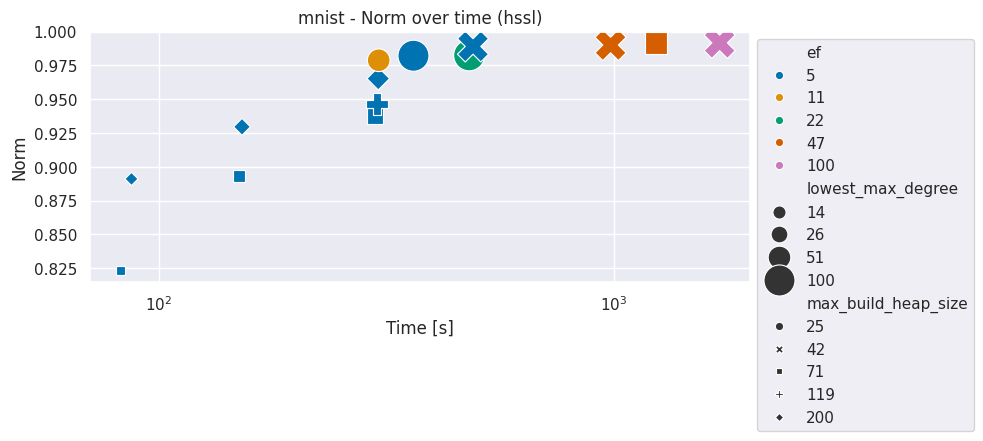

In [29]:
sns.set(style="darkgrid")
ax = plt.figure(figsize=(10, 4))

sns.scatterplot(data=pareto_mnisthssl, x="time", y="norm", 
                hue="ef",
                style="max_build_heap_size", 
                size="lowest_max_degree", 
                palette="colorblind", 
                # markers={True: "X", False: "o"},
                sizes=(90, 500))

plt.title(f"mnist - Norm over time (hssl)")
plt.xlabel("Time [s]")
plt.ylabel("Norm")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.xscale("log")

plt.show()

## Quality Measurements MNIST Kruskal

coph_dist took: 43.42864918708801s


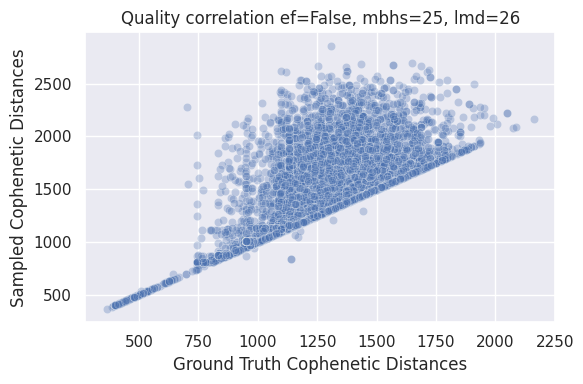

0.16060901547761056
norm took: 0.9612584114074707s
coph_dist took: 43.47383785247803s


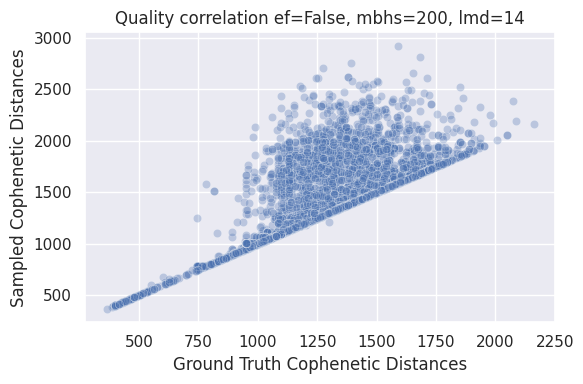

0.1145868599900248
norm took: 0.9774458408355713s
coph_dist took: 43.693994760513306s


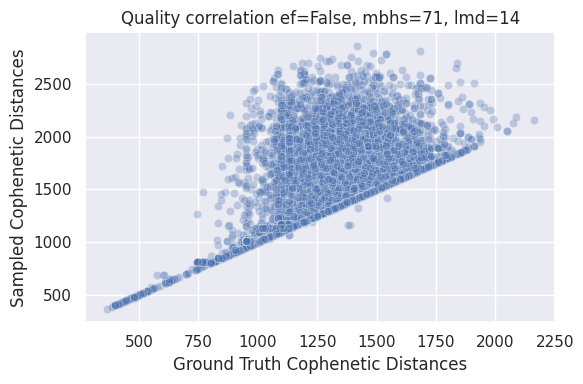

0.19834552793505744
norm took: 0.9705877304077148s
coph_dist took: 43.24316167831421s


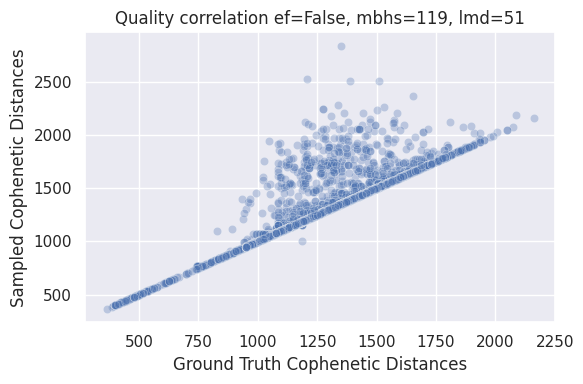

0.04943482094137534
norm took: 0.9777734279632568s
coph_dist took: 43.5238823890686s


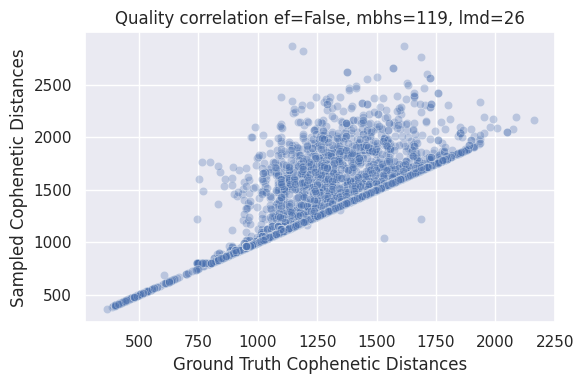

0.089638295673476
norm took: 0.9823229312896729s
coph_dist took: 43.35471510887146s


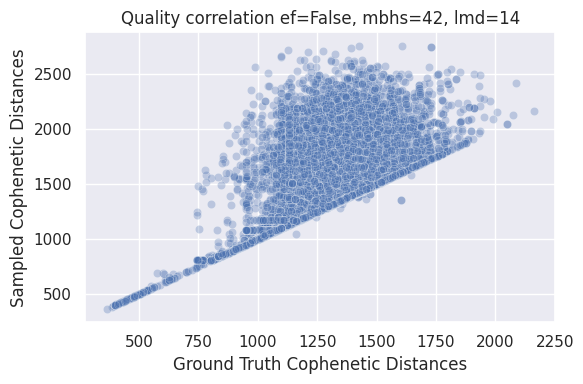

0.20541167984058786
norm took: 0.9818756580352783s
coph_dist took: 43.32125377655029s


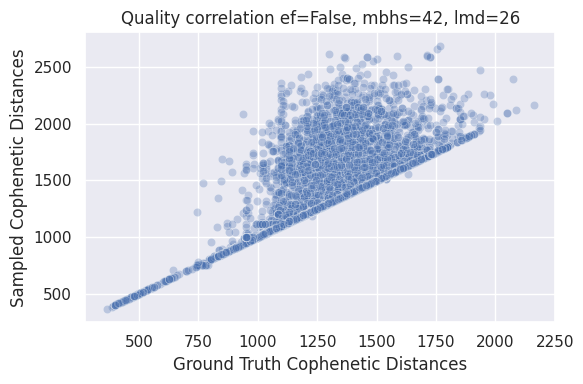

0.12088352435770909
norm took: 0.9791638851165771s
coph_dist took: 43.57192397117615s


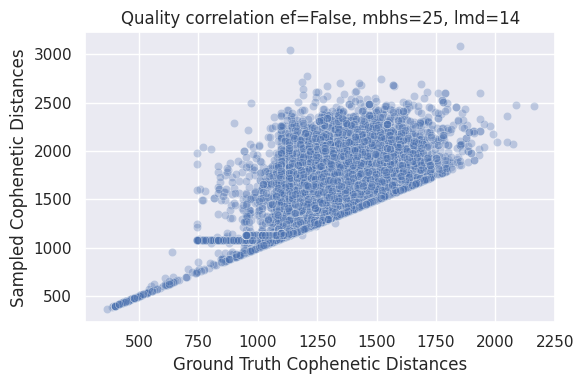

0.1949582866535385
norm took: 0.9778499603271484s
coph_dist took: 43.22004580497742s


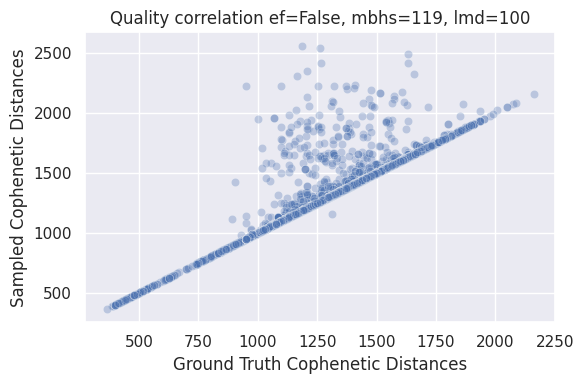

0.04345785364429908
norm took: 0.9639499187469482s
coph_dist took: 43.211182832717896s


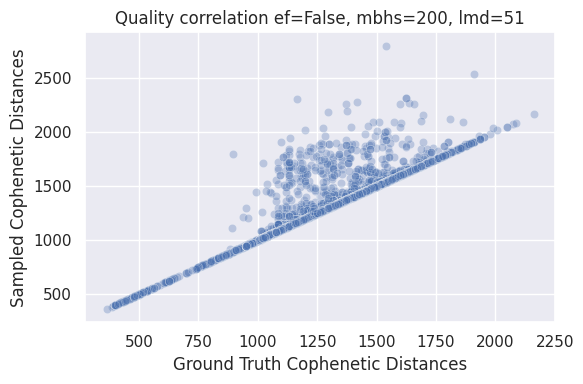

0.04322152000780333
norm took: 0.9645800590515137s
coph_dist took: 43.62240219116211s
0.16163773785696645
norm took: 0.9774281978607178s
coph_dist took: 43.40362739562988s
0.07099022337851439
norm took: 0.9742298126220703s
coph_dist took: 43.12865161895752s
0.018646448660280365
norm took: 0.9793076515197754s
coph_dist took: 43.231587171554565s
0.0190996489681102
norm took: 0.9786067008972168s
coph_dist took: 43.16354179382324s
0.03308069152979814
norm took: 0.971498966217041s
coph_dist took: 43.36258912086487s
0.13504187626202357
norm took: 0.9642255306243896s
coph_dist took: 43.851346254348755s
0.0657617948127959
norm took: 0.982215166091919s
coph_dist took: 43.88954210281372s
0.022704430719445497
norm took: 0.9746019840240479s
coph_dist took: 59.1651508808136s
0.024035942482427214
norm took: 0.9696037769317627s
coph_dist took: 44.044821977615356s
0.039096703407342795
norm took: 0.9538657665252686s
0


algo       time      n  \
0  HNSWkruskal  15.554245  70000   
1  HNSWkruskal  16.572302  70000   
2  HNSWkruskal  15.253799  70000   
3  HNSWkruskal  23.377166  70000   
4  HNSWkruskal  15.705465  70000   

                                              params      norm  
0  {"minPts": 1, "symmetric_expand": false, "para...  0.839391  
1  {"minPts": 1, "symmetric_expand": false, "para...  0.885413  
2  {"minPts": 1, "symmetric_expand": false, "para...  0.801654  
3  {"minPts": 1, "symmetric_expand": false, "para...  0.950565  
4  {"minPts": 1, "symmetric_expand": false, "para...  0.910362

In [30]:
## -- mnist-kruskal -- ##
import time
import itertools

dataset = 'mnist-70k'

se = [False]
mbhs = [25, 42, 71, 119, 200]
lmd = [14, 26, 51, 100]

# Generate all combinations
combinations = list(itertools.product(se, mbhs, lmd))

data = []


temp = 0
error_count = 0
for f in load_all_results(dataset, ""):
    if f.attrs['algo'] != "HNSWkruskal": continue
    params = json.loads(f.attrs["params"])
    
    if (params['symmetric_expand'],
        params['params']['max_build_heap_size'], 
        params['params']['lowest_max_degree']) not in combinations: continue
    try:
        dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in f["dendrogram"][:]]
        dendro = elki_sort_dendrogram(dendro)

        try:
            start = time.time()
            coph_dists = cophenet(dendro)
            end = time.time()
            t = end - start
            print(f"coph_dist took: {t}s")
        except:
            print("ERROR in cophenet")
            error_count += 1

        sampled_gt_coph_dists = gt_coph_dists[indices]
        sampled_coph_dists = np.sqrt(coph_dists[indices])

        temp += 1
        if temp <= 10:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=sampled_gt_coph_dists[0:10000], y=sampled_coph_dists[0:10000], alpha=0.3)
            plt.title(f"Quality correlation ef={params['symmetric_expand']}, mbhs={params['params']['max_build_heap_size']}, lmd={params['params']['lowest_max_degree']}")
            plt.xlabel("Ground Truth Cophenetic Distances")
            plt.ylabel("Sampled Cophenetic Distances")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        start = time.time()
        max_diff = max(sampled_gt_coph_dists) - min(sampled_gt_coph_dists)
        norm = np.linalg.norm(sampled_gt_coph_dists - sampled_coph_dists) / ( np.sqrt(len(sampled_gt_coph_dists)) * max_diff )
        print(norm)
        end = time.time()
        t = end - start
        print(f"norm took: {t}s")

        data.append({
        "algo": f.attrs['algo'],
        "time": f.attrs['time'],
        "n": len(f["dendrogram"][:]) + 1,
        "params": f.attrs["params"],
        "norm": 1 - norm,
        })
    finally:
        f.close()

print(error_count)
df_MNISTkruskal = pd.DataFrame(data=data)
df_MNISTkruskal.head(5)

In [31]:
df_MNISTkruskal_split = df_MNISTkruskal
df_MNISTkruskal_split["params_dict"] = df_MNISTkruskal_split["params"].apply(lambda x: json.loads(x))
df_ef = df_MNISTkruskal_split["params_dict"].apply(lambda d: d.get("symmetric_expand")).rename("symmetric_expand").to_frame()
df_params = df_MNISTkruskal_split["params_dict"].apply(lambda d: d.get("params", {})).apply(pd.Series)
df_MNISTkruskal_split = pd.concat([df_MNISTkruskal_split, df_ef[['symmetric_expand']], df_params[["lowest_max_degree", "max_build_heap_size"]]], axis=1)

df_MNISTkruskal_split

algo       time      n  \
0   HNSWkruskal  15.554245  70000   
1   HNSWkruskal  16.572302  70000   
2   HNSWkruskal  15.253799  70000   
3   HNSWkruskal  23.377166  70000   
4   HNSWkruskal  15.705465  70000   
5   HNSWkruskal  17.661479  70000   
6   HNSWkruskal  14.391205  70000   
7   HNSWkruskal  16.918314  70000   
8   HNSWkruskal  33.872446  70000   
9   HNSWkruskal  25.552272  70000   
10  HNSWkruskal  14.974581  70000   
11  HNSWkruskal  21.577345  70000   
12  HNSWkruskal  27.754680  70000   
13  HNSWkruskal  33.217834  70000   
14  HNSWkruskal  33.386465  70000   
15  HNSWkruskal  16.113104  70000   
16  HNSWkruskal  17.429884  70000   
17  HNSWkruskal  23.621367  70000   
18  HNSWkruskal  21.729967  70000   
19  HNSWkruskal  22.835749  70000   

                                               params      norm  \
0   {"minPts": 1, "symmetric_expand": false, "para...  0.839391   
1   {"minPts": 1, "symmetric_expand": false, "para...  0.885413   
2   {"minPts": 1, "symmetric_expand": false, "para...  0.801654   
3   {"minPts": 1, "symmetric_expand": false, "para...  0.950565   
4   {"minPts": 1, "symmetric_expand": false, "para...  0.910362   
5   {"minPts": 1, "symmetric_expand": false, "para...  0.794588   
6   {"minPts": 1, "symmetric_expand": false, "para...  0.879116   
7   {"minPts": 1, "symmetric_expand": false, "para...  0.805042   
8   {"minPts": 1, "symmetric_expand": false, "para...  0.956542   
9   {"minPts": 1, "symmetric_expand": false, "para...  0.956778   
10  {"minPts": 1, "symmetric_expand": false, "para...  0.838362   
11  {"minPts": 1, "symmetric_expand": false, "para...  0.929010   
12  {"minPts": 1, "symmetric_expand": false, "para...  0.981354   
13  {"minPts": 1, "symmetric_expand": false, "para...  0.980900   
14  {"minPts": 1, "symmetric_expand": false, "para...  0.966919   
15  {"minPts": 1, "symmetric_expand": false, "para...  0.864958   
16  {"minPts": 1, "symmetric_expand": false, "para...  0.934238   
17  {"minPts": 1, "symmetric_expand": false, "para...  0.977296   
18  {"minPts": 1, "symmetric_expand": false, "para...  0.975964   
19  {"minPts": 1, "symmetric_expand": false, "para...  0.960903   

                                          params_dict  symmetric_expand  \
0   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
1   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
2   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
3   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
4   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
5   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
6   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
7   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
8   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
9   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
10  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
11  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
12  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
13  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
14  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
15  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
16  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
17  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
18  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
19  {'minPts': 1, 'symmetric_expand': False, 'para...             False   

    lowest_max_degree  max_build_heap_size  
0                  26                   25  
1                  14                  200  
2                  14                   71  
3                  51                  119  
4                  26   

In [32]:
df_MNISTkruskal_split.to_csv('MNISTkruskal_norm.csv', index=False)

In [33]:
df_MNISTkruskal_split = df_MNISTkruskal_split[["algo", "time", "norm", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

pareto_mnistkruskal = get_pareto_frontier(df_MNISTkruskal_split, "time", "norm", "algo")

pareto_mnistkruskal[["time", "norm", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time      norm  symmetric_expand  max_build_heap_size  \
0   14.391205  0.879116             False                   42   
4   15.705465  0.910362             False                  119   
8   17.429884  0.934238             False                  200   
11  21.729967  0.975964             False                   25   
14  23.621367  0.977296             False                   25   
16  27.754680  0.981354             False                   42   

    lowest_max_degree  
0                  26  
4                  26  
8                  26  
11                 51  
14                100  
16                100

In [34]:
filtered_df = pareto_mnistkruskal[pareto_mnistkruskal["norm"] > 0.8]

opt = filtered_df[filtered_df.time == filtered_df.time.min()]

opt[["time", "norm", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time      norm  symmetric_expand  max_build_heap_size  \
0  14.391205  0.879116             False                   42   

   lowest_max_degree  
0                 26

In [35]:
pareto_mnistkruskal = pareto_mnistkruskal[["time", "norm", "max_build_heap_size", "lowest_max_degree"]]

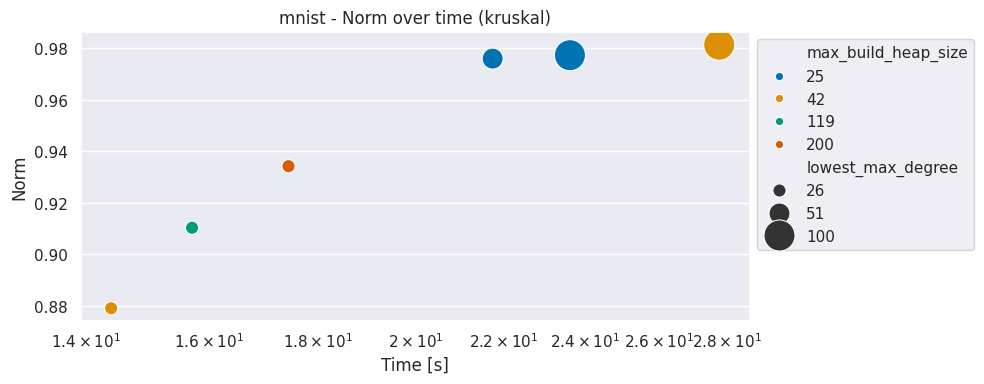

In [36]:
sns.set(style="darkgrid")
ax = plt.figure(figsize=(10, 4))

sns.scatterplot(data=pareto_mnistkruskal, x="time", y="norm", 
                hue="max_build_heap_size",
                size="lowest_max_degree",
                palette="colorblind", 
                # markers={True: "X", False: "o"},
                sizes=(90, 500))

plt.title(f"mnist - Norm over time (kruskal)")
plt.xlabel("Time [s]")
plt.ylabel("Norm")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.xscale("log")

plt.show()

## Quality Measurements MNIST MST

coph_dist took: 48.82420563697815s


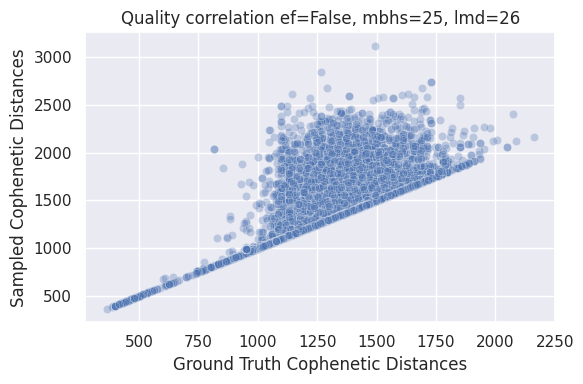

0.14009169300157295
norm took: 0.9771041870117188s
coph_dist took: 44.53890562057495s


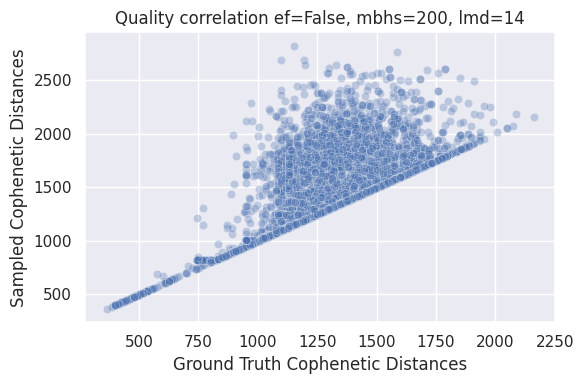

0.12337884742075601
norm took: 0.9832668304443359s
coph_dist took: 44.475807666778564s


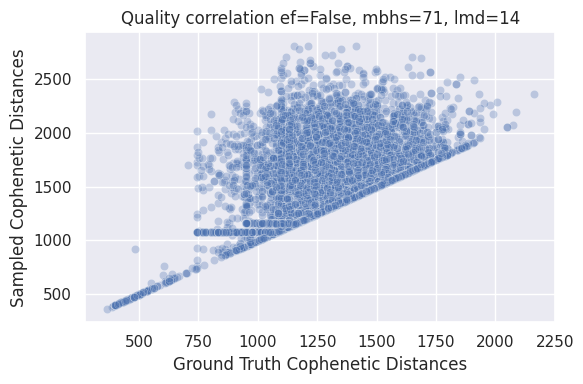

0.20159810395976221
norm took: 0.9665992259979248s
coph_dist took: 44.03643202781677s


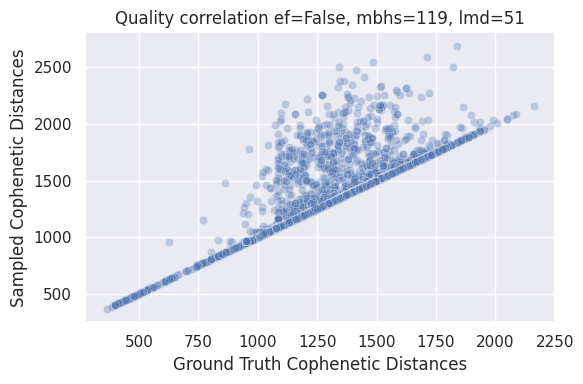

0.06213637897794485
norm took: 0.9891140460968018s
coph_dist took: 44.02885293960571s


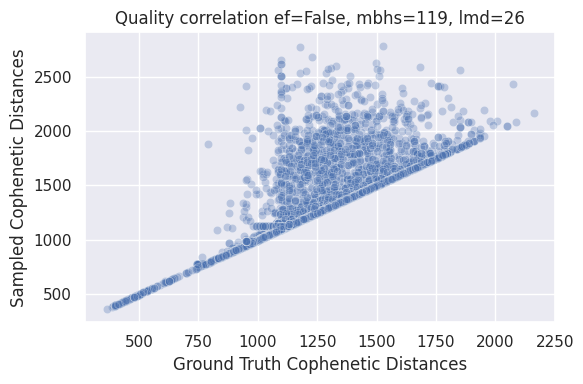

0.09666895387795846
norm took: 0.9737603664398193s
coph_dist took: 44.2976291179657s


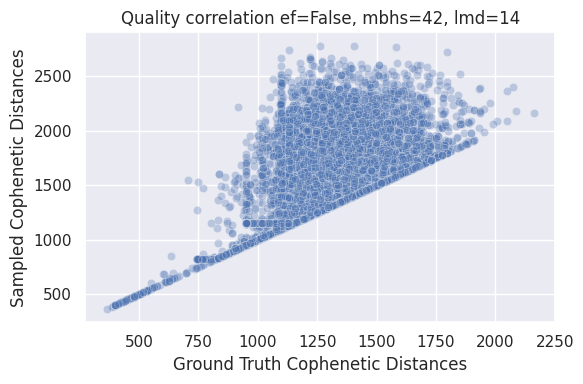

0.21359911267117151
norm took: 0.9757404327392578s
coph_dist took: 44.249510049819946s


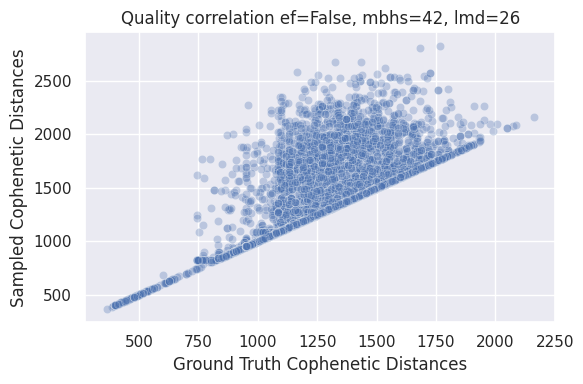

0.13179357340152575
norm took: 0.9773328304290771s
coph_dist took: 44.67949390411377s


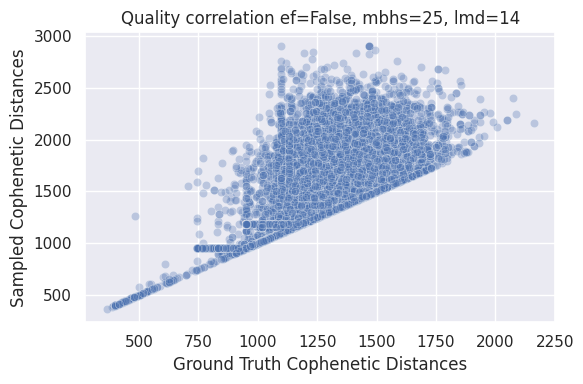

0.22319429410649555
norm took: 0.9777216911315918s
coph_dist took: 44.03409290313721s


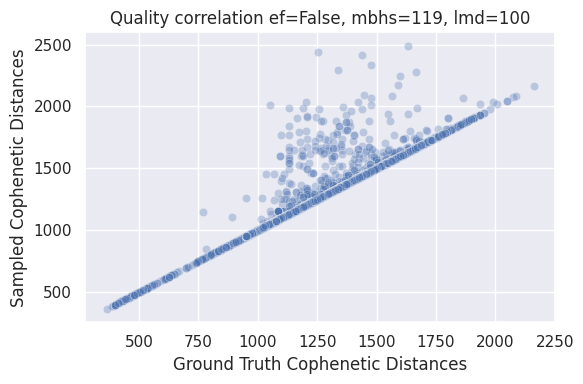

0.0357381353226991
norm took: 0.986069917678833s
coph_dist took: 43.951287031173706s


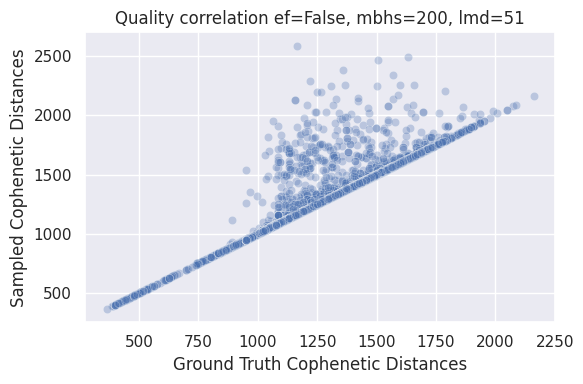

0.04585882848431214
norm took: 0.9730997085571289s
coph_dist took: 44.15087008476257s
0.09844462137341986
norm took: 0.9705548286437988s
coph_dist took: 44.096559047698975s
0.056612872627186485
norm took: 0.9749999046325684s
coph_dist took: 43.90200686454773s
0.018105771454407154
norm took: 0.9793422222137451s
coph_dist took: 44.08313703536987s
0.022795776613779503
norm took: 0.9604101181030273s
coph_dist took: 44.08619046211243s
0.026309712947491477
norm took: 0.9839365482330322s
coph_dist took: 44.27650809288025s
0.12805194029617797
norm took: 0.9699504375457764s
coph_dist took: 44.077672719955444s
0.07197131077784437
norm took: 0.9679503440856934s
coph_dist took: 44.01623225212097s
0.023731925025320736
norm took: 0.974581241607666s
coph_dist took: 43.989001989364624s
0.028950853922173864
norm took: 0.9623837471008301s
coph_dist took: 43.98407864570618s
0.032989974238731117
norm took: 0.9735021591186523s
0


algo      time      n  \
0  HNSWmst  1.840610  70000   
1  HNSWmst  2.985336  70000   
2  HNSWmst  1.681333  70000   
3  HNSWmst  4.734183  70000   
4  HNSWmst  3.143082  70000   

                                              params      norm  
0  {"minPts": 1, "symmetric_expand": false, "para...  0.859908  
1  {"minPts": 1, "symmetric_expand": false, "para...  0.876621  
2  {"minPts": 1, "symmetric_expand": false, "para...  0.798402  
3  {"minPts": 1, "symmetric_expand": false, "para...  0.937864  
4  {"minPts": 1, "symmetric_expand": false, "para...  0.903331

In [37]:
## -- mnist-mst -- ##
import time
import itertools

dataset = 'mnist-70k'

se = [False]
mbhs = [25, 42, 71, 119, 200]
lmd = [14, 26, 51, 100]

# Generate all combinations
combinations = list(itertools.product(se, mbhs, lmd))

data = []


temp = 0
error = 0
for f in load_all_results(dataset, ""):
    if f.attrs['algo'] != "HNSWmst": continue
    params = json.loads(f.attrs["params"])
    
    if (params['symmetric_expand'],
        params['params']['max_build_heap_size'], 
        params['params']['lowest_max_degree']) not in combinations: continue
    try:
        dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in f["dendrogram"][:]]
        dendro = elki_sort_dendrogram(dendro)

        try:
            start = time.time()
            coph_dists = cophenet(dendro)
            end = time.time()
            t = end - start
            print(f"coph_dist took: {t}s")
        except:
            print("ERROR in cophenet")
            error_count += 1

        sampled_gt_coph_dists = gt_coph_dists[indices]
        sampled_coph_dists = np.sqrt(coph_dists[indices])

        temp += 1
        if temp <= 10:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=sampled_gt_coph_dists[0:10000], y=sampled_coph_dists[0:10000], alpha=0.3)
            plt.title(f"Quality correlation ef={params['symmetric_expand']}, mbhs={params['params']['max_build_heap_size']}, lmd={params['params']['lowest_max_degree']}")
            plt.xlabel("Ground Truth Cophenetic Distances")
            plt.ylabel("Sampled Cophenetic Distances")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        start = time.time()
        max_diff = max(sampled_gt_coph_dists) - min(sampled_gt_coph_dists)
        norm = np.linalg.norm(sampled_gt_coph_dists - sampled_coph_dists) / ( np.sqrt(len(sampled_gt_coph_dists)) * max_diff )
        print(norm)
        end = time.time()
        t = end - start
        print(f"norm took: {t}s")

        data.append({
        "algo": f.attrs['algo'],
        "time": f.attrs['time'],
        "n": len(f["dendrogram"][:]) + 1,
        "params": f.attrs["params"],
        "norm": 1 - norm,
        })
    finally:
        f.close()

print(error_count)
df_MNISTmst = pd.DataFrame(data=data)
df_MNISTmst.head(5)

In [38]:
df_MNISTmst_split = df_MNISTmst
df_MNISTmst_split["params_dict"] = df_MNISTmst_split["params"].apply(lambda x: json.loads(x))
df_ef = df_MNISTmst_split["params_dict"].apply(lambda d: d.get("symmetric_expand")).rename("symmetric_expand").to_frame()
df_params = df_MNISTmst_split["params_dict"].apply(lambda d: d.get("params", {})).apply(pd.Series)
df_MNISTmst_split = pd.concat([df_MNISTmst_split, df_ef[['symmetric_expand']], df_params[["lowest_max_degree", "max_build_heap_size"]]], axis=1)

df_MNISTmst_split

algo      time      n  \
0   HNSWmst  1.840610  70000   
1   HNSWmst  2.985336  70000   
2   HNSWmst  1.681333  70000   
3   HNSWmst  4.734183  70000   
4   HNSWmst  3.143082  70000   
5   HNSWmst  1.290381  70000   
6   HNSWmst  2.108674  70000   
7   HNSWmst  1.099854  70000   
8   HNSWmst  7.304697  70000   
9   HNSWmst  6.050233  70000   
10  HNSWmst  2.581286  70000   
11  HNSWmst  3.806858  70000   
12  HNSWmst  4.423545  70000   
13  HNSWmst  6.184672  70000   
14  HNSWmst  8.978653  70000   
15  HNSWmst  2.254181  70000   
16  HNSWmst  4.120671  70000   
17  HNSWmst  2.781672  70000   
18  HNSWmst  2.438128  70000   
19  HNSWmst  3.261788  70000   

                                               params      norm  \
0   {"minPts": 1, "symmetric_expand": false, "para...  0.859908   
1   {"minPts": 1, "symmetric_expand": false, "para...  0.876621   
2   {"minPts": 1, "symmetric_expand": false, "para...  0.798402   
3   {"minPts": 1, "symmetric_expand": false, "para...  0.937864   
4   {"minPts": 1, "symmetric_expand": false, "para...  0.903331   
5   {"minPts": 1, "symmetric_expand": false, "para...  0.786401   
6   {"minPts": 1, "symmetric_expand": false, "para...  0.868206   
7   {"minPts": 1, "symmetric_expand": false, "para...  0.776806   
8   {"minPts": 1, "symmetric_expand": false, "para...  0.964262   
9   {"minPts": 1, "symmetric_expand": false, "para...  0.954141   
10  {"minPts": 1, "symmetric_expand": false, "para...  0.901555   
11  {"minPts": 1, "symmetric_expand": false, "para...  0.943387   
12  {"minPts": 1, "symmetric_expand": false, "para...  0.981894   
13  {"minPts": 1, "symmetric_expand": false, "para...  0.977204   
14  {"minPts": 1, "symmetric_expand": false, "para...  0.973690   
15  {"minPts": 1, "symmetric_expand": false, "para...  0.871948   
16  {"minPts": 1, "symmetric_expand": false, "para...  0.928029   
17  {"minPts": 1, "symmetric_expand": false, "para...  0.976268   
18  {"minPts": 1, "symmetric_expand": false, "para...  0.971049   
19  {"minPts": 1, "symmetric_expand": false, "para...  0.967010   

                                          params_dict  symmetric_expand  \
0   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
1   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
2   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
3   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
4   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
5   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
6   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
7   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
8   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
9   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
10  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
11  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
12  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
13  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
14  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
15  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
16  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
17  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
18  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
19  {'minPts': 1, 'symmetric_expand': False, 'para...             False   

    lowest_max_degree  max_build_heap_size  
0                  26                   25  
1                  14                  200  
2                  14                   71  
3                  51                  119  
4                  26                  119  
5                  14                   42  
6                  26              

In [39]:
df_MNISTmst_split.to_csv('MNISTmst_norm.csv', index=False)

In [40]:
df_MNISTmst_split = df_MNISTmst_split[["algo", "time", "norm", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

pareto_mnistmst = get_pareto_frontier(df_MNISTmst_split, "time", "norm", "algo")

pareto_mnistmst[["time", "norm", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time      norm  symmetric_expand  max_build_heap_size  \
0   1.099854  0.776806             False                   25   
1   1.290381  0.786401             False                   42   
2   1.681333  0.798402             False                   71   
3   1.840610  0.859908             False                   25   
4   2.108674  0.868206             False                   42   
5   2.254181  0.871948             False                  119   
6   2.438128  0.971049             False                   25   
8   2.781672  0.976268             False                   25   
14  4.423545  0.981894             False                   42   

    lowest_max_degree  
0                  14  
1                  14  
2                  14  
3                  26  
4                  26  
5                  14  
6                  51  
8                 100  
14                100

In [41]:
filtered_df = pareto_mnistmst[pareto_mnistmst["norm"] > 0.8]

opt = filtered_df[filtered_df.time == filtered_df.time.min()]

opt[["time", "norm", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time      norm  symmetric_expand  max_build_heap_size  lowest_max_degree
3  1.84061  0.859908             False                   25                 26

In [42]:
pareto_mnistmst = pareto_mnistmst[["time", "norm", "max_build_heap_size", "lowest_max_degree"]]

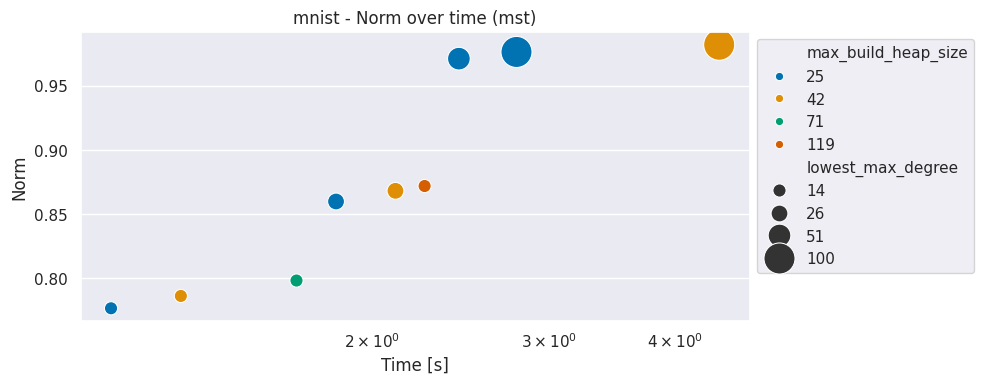

In [43]:
sns.set(style="darkgrid")
ax = plt.figure(figsize=(10, 4))

sns.scatterplot(data=pareto_mnistmst, x="time", y="norm", 
                hue="max_build_heap_size",
                size="lowest_max_degree",
                palette="colorblind", 
                # markers={True: "X", False: "o"},
                sizes=(90, 500))

plt.title(f"mnist - Norm over time (mst)")
plt.xlabel("Time [s]")
plt.ylabel("Norm")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.xscale("log")

plt.show()

# break

In [ ]:
# df_ALOIhssl = pd.read_csv("ALOIhssl.csv")
# df_ALOIkruskal = pd.read_csv("ALOIkruskal.csv")
# df_ALOImst = pd.read_csv("ALOImst.csv")
# df_MNISThssl = pd.read_csv("MNISThssl.csv")
# df_MNISTkruskal = pd.read_csv("MNISTkruskal.csv")
# df_MNISTmst = pd.read_csv("MNISTmst.csv")
